In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# ============================================
# PCOS Clinical Modeling — Fully Documented Pipeline
# MODIFICATIONS:
# - Restructured into cell-by-cell format
# - Added robust 5-fold OOF evaluation with per-fold calibration
# - Added specific artifact generation for comparative analysis (tab_*)
# - Added detailed thresholding (Youden's J, Spec>=0.80, 85/85)
# - Added comprehensive latency benchmarking (bs=1, 8, 32)
# ============================================

import warnings, json, os, time
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from joblib import dump

from scipy.stats import randint, loguniform

from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, StratifiedKFold
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve, confusion_matrix,
    f1_score, brier_score_loss
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from xgboost import XGBClassifier
import shap

# --- Global Config ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
clinical_data_path = "/content/drive/MyDrive/PCOS_data.csv"  # <-- set to your CSV
TARGET_COLUMN = "PCOS (Y/N)"

# --- Artifact Configuration (UPDATED) ---
SAVE_ARTIFACTS = True
ARTIFACT_DIR = "./tab_artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# Filenames for the paper table
FN_OOF_METRICS = os.path.join(ARTIFACT_DIR, "tab_oof_metrics_ci.json")
FN_THRESHOLDS  = os.path.join(ARTIFACT_DIR, "tab_thresholds.json")
FN_LATENCY     = os.path.join(ARTIFACT_DIR, "tab_latency_report.json")
FN_OOF_PROBS   = os.path.join(ARTIFACT_DIR, "tab_oof_probs.npy")
FN_OOF_Y       = os.path.join(ARTIFACT_DIR, "tab_oof_y.npy")

In [25]:
import shutil
import os

# This variable should already be defined in your first cell
ARTIFACT_DIR = "./tab_artifacts"

# Check if the directory exists before attempting to delete it
if os.path.exists(ARTIFACT_DIR):
    try:
        # This command recursively deletes the directory and all its contents
        shutil.rmtree(ARTIFACT_DIR)
        print(f"✅ Successfully deleted old artifacts directory: {ARTIFACT_DIR}")
    except OSError as e:
        print(f"Error: {e.strerror} - Could not delete {ARTIFACT_DIR}")
else:
    print(f"Directory '{ARTIFACT_DIR}' not found, nothing to delete.")

# Re-create the directory so the script can save new files
os.makedirs(ARTIFACT_DIR, exist_ok=True)
print(f"Re-created empty directory: {ARTIFACT_DIR}")

✅ Successfully deleted old artifacts directory: ./tab_artifacts
Re-created empty directory: ./tab_artifacts


In [26]:
def bootstrap_ci(y_true, y_score, metric_fn, n_boot=2000, alpha=0.95, seed=42):
    """
    Generic bootstrap CI for a score-based metric (e.g., AUROC, AUPRC).
    Returns (point_estimate, (lo, hi)).
    """
    rng = np.random.default_rng(seed)
    n = len(y_true)
    vals = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        vals.append(metric_fn(y_true[idx], y_score[idx]))
    lo = float(np.percentile(vals, (1-alpha)/2*100))
    hi = float(np.percentile(vals, (1+alpha)/2*100))
    pe = float(metric_fn(y_true, y_score))
    return pe, (lo, hi)

In [27]:
### Cell 3: Data Loading and Initial Cleaning (Corrected)

# ============ Load & Clean Data ============
df = pd.read_csv(clinical_data_path)
df.columns = df.columns.str.strip()

# Coerce known numeric text columns if present
for col in ['II beta-HCG(mIU/mL)', 'AMH(ng/mL)']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop obvious ID/empty columns (adjust list to your CSV)
drop_cols = [c for c in ['Sl. No', 'Patient File No.', 'Unnamed: 44'] if c in df.columns]
df_cleaned = df.drop(columns=drop_cols)

assert TARGET_COLUMN in df_cleaned.columns, f"Missing target column: {TARGET_COLUMN}"
df_cleaned[TARGET_COLUMN] = df_cleaned[TARGET_COLUMN].astype(int)

X_full = df_cleaned.drop(columns=[TARGET_COLUMN])
y_full = df_cleaned[TARGET_COLUMN]

# ====================================================================
# NEW: Flip the labels so 1 = healthy and 0 = unhealthy (PCOS)
# ====================================================================
y_full = 1 - y_full

print("\n--- Label Mapping Corrected ---")
print("New mapping: 0 = unhealthy (PCOS), 1 = healthy (no PCOS)")
print(f"Value Counts -> 0 (PCOS): {int((y_full==0).sum())}, 1 (Healthy): {int((y_full==1).sum())}")
# ====================================================================


# Identify dtypes
numeric_cols = X_full.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_full.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print(f"\nColumns: numeric={len(numeric_cols)}, categorical={len(categorical_cols)}")
print(f"Shape (full): {X_full.shape}, positives={y_full.sum()} ({y_full.mean():.3f} prevalence)")


--- Label Mapping Corrected ---
New mapping: 0 = unhealthy (PCOS), 1 = healthy (no PCOS)
Value Counts -> 0 (PCOS): 177, 1 (Healthy): 364

Columns: numeric=40, categorical=1
Shape (full): (541, 41), positives=364 (0.673 prevalence)


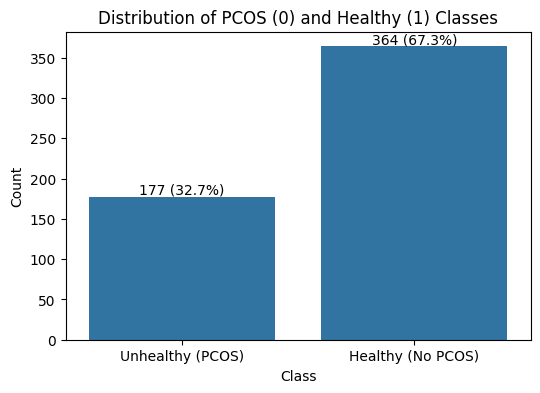

In [28]:
# ============ Visualize Class Distribution ============
import matplotlib.pyplot as plt
import seaborn as sns

# Get value counts and sort by index for consistent plotting
class_counts = y_full.value_counts().sort_index()

plt.figure(figsize=(6, 4))
# Normalize RGBA values to be between 0 and 1
rgba_color = (31/255, 119/255, 180/255, 255/255)
ax = sns.barplot(x=class_counts.index, y=class_counts.values, color=rgba_color)
plt.xticks(ticks=[0, 1], labels=["Unhealthy (PCOS)", "Healthy (No PCOS)"])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Distribution of PCOS (0) and Healthy (1) Classes")

# Add values on top of bars
total = len(y_full)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(f'{int(y)} ({percentage})', (x, y), ha='center', va='bottom')

plt.show()

In [29]:
# ============ Preprocessing pipelines ============
num_tf = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
])

cat_tf = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_tf, numeric_cols),
        ('cat', cat_tf, categorical_cols)
    ],
    remainder='drop'
)

In [30]:
# ============ Train/Test split for tuning ============
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.20, stratify=y_full, random_state=RANDOM_STATE
)
neg_pos_ratio = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Split for tuning: Train={X_train.shape}, Test={X_test.shape}, Neg/Pos={neg_pos_ratio:.2f}")

# ============ Hyperparameter tuning (RandomizedSearchCV) ============
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        random_state=RANDOM_STATE,
        eval_metric='logloss',
        tree_method='hist',
        n_jobs=-1
    ))
])

param_dist_xgb = {
    'classifier__n_estimators': randint(200, 800),
    'classifier__learning_rate': loguniform(1e-2, 3e-1),
    'classifier__max_depth': randint(3, 10),
    'classifier__min_child_weight': randint(1, 10),
    'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'classifier__gamma': [0, 0.1, 0.25, 0.5, 1.0],
    'classifier__reg_alpha': [0, 0.1, 1.0, 5.0, 10.0],
    'classifier__reg_lambda': [0.1, 1.0, 5.0, 10.0],
    'classifier__scale_pos_weight': [neg_pos_ratio]
}

print("\n--- Tuning XGBoost (RandomizedSearchCV) ---")
xgb_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_dist_xgb,
    n_iter=120, cv=5, n_jobs=-1,
    random_state=RANDOM_STATE,
    scoring='roc_auc', verbose=1
)
xgb_search.fit(X_train, y_train)

print("\nBest XGBoost params found:", xgb_search.best_params_)

Split for tuning: Train=(432, 41), Test=(109, 41), Neg/Pos=0.48

--- Tuning XGBoost (RandomizedSearchCV) ---
Fitting 5 folds for each of 120 candidates, totalling 600 fits

Best XGBoost params found: {'classifier__colsample_bytree': 0.6, 'classifier__gamma': 1.0, 'classifier__learning_rate': np.float64(0.03438084743887886), 'classifier__max_depth': 4, 'classifier__min_child_weight': 2, 'classifier__n_estimators': 642, 'classifier__reg_alpha': 1.0, 'classifier__reg_lambda': 0.1, 'classifier__scale_pos_weight': np.float64(0.4845360824742268), 'classifier__subsample': 1.0}


In [31]:
# ====================================================================
# START: NEW CODE BLOCK FOR OOF EVALUATION AND ARTIFACT GENERATION
# ====================================================================

def youden_threshold(y_true, y_score):
    fpr, tpr, thr = roc_curve(y_true, y_score)
    J = tpr - fpr
    i = int(np.argmax(J))
    return float(thr[i]), float(tpr[i]), float(1 - fpr[i])

def spec80_threshold(y_true, y_score):
    fpr, tpr, thr = roc_curve(y_true, y_score)
    mask = fpr <= 0.20  # Spec >= 0.80
    if not np.any(mask):
        # pick closest to 0.80 if infeasible
        i = int(np.argmin(np.abs((1 - fpr) - 0.80)))
    else:
        idx = np.where(mask)[0]
        i = int(idx[np.argmax(tpr[mask])])  # maximize sensitivity subject to Spec>=0.80
    return float(thr[i]), float(tpr[i]), float(1 - fpr[i])

def thr_85_85(y_true, y_score):
    fpr, tpr, thr = roc_curve(y_true, y_score)
    spec = 1 - fpr
    ok = (tpr >= 0.85) & (spec >= 0.85)
    if np.any(ok):
        idx = np.where(ok)[0]
        i = int(idx[np.argmax(tpr[idx] + spec[idx])])  # best combined margin
    else:
        # closest (Euclidean distance) to (0.85, 0.85)
        dist = (tpr - 0.85)**2 + (spec - 0.85)**2
        i = int(np.argmin(dist))
    return float(thr[i]), float(tpr[i]), float(spec[i])

def confusion_metrics(y_true, y_score, thr):
    yhat = (y_score >= thr).astype(int)
    cm = confusion_matrix(y_true, yhat)
    tn, fp, fn, tp = cm.ravel()
    sens = tp / (tp + fn + 1e-9)
    spec = tn / (tn + fp + 1e-9)
    acc  = (tp + tn) / (tn + fp + fn + tp + 1e-9)
    f1   = f1_score(y_true, yhat)
    J    = sens + spec - 1
    return dict(tp=int(tp), fp=int(fp), fn=int(fn), tn=int(tn),
                sensitivity=float(sens), specificity=float(spec),
                accuracy=float(acc), f1=float(f1), J=float(J))

def plot_and_save_roc_pr(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    prec, rec, _ = precision_recall_curve(y_true, y_score)

    plt.figure(); plt.plot(fpr, tpr, lw=2); plt.plot([0,1], [0,1], '--', alpha=0.6)
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC (OOF)'); plt.grid(alpha=0.2)
    plt.savefig(os.path.join(ARTIFACT_DIR, "tab_roc.png"), dpi=200); plt.close()

    plt.figure(); plt.plot(rec, prec, lw=2)
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR (OOF)'); plt.grid(alpha=0.2)
    plt.savefig(os.path.join(ARTIFACT_DIR, "tab_pr.png"), dpi=200); plt.close()

def plot_and_save_reliability(y_true, y_score):
    prob_true, prob_pred = calibration_curve(y_true, y_score, n_bins=10, strategy='quantile')
    plt.figure()
    plt.plot([0,1], [0,1], '--', alpha=0.6, label='Perfect')
    plt.plot(prob_pred, prob_true, marker='o', label='OOF')
    plt.xlabel('Predicted'); plt.ylabel('Observed'); plt.title('Reliability (OOF)')
    plt.legend(); plt.grid(alpha=0.2)
    plt.savefig(os.path.join(ARTIFACT_DIR, "tab_reliability.png"), dpi=200); plt.close()

def plot_and_save_cm(y_true, y_score, thr, fname):
    yhat = (y_score >= thr).astype(int)
    cm = confusion_matrix(y_true, yhat)
    plt.figure(figsize=(5.2,4.6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No PCOS', 'PCOS'],
                yticklabels=['No PCOS', 'PCOS'])
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title(os.path.splitext(fname)[0])
    plt.tight_layout()
    plt.savefig(os.path.join(ARTIFACT_DIR, fname), dpi=200); plt.close()

def save_json(path, obj):
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

In [32]:
print("\n=== 5-fold CV with per-fold calibration (OOF) ===")

# Use the best parameters found during the tuning phase
if 'xgb_search' in globals():
    xgb_best_params = {
        k.replace('classifier__', ''): v
        for k, v in xgb_search.best_params_.items()
        if k.startswith('classifier__')
    }
else:  # Fallback if tuning was skipped
    xgb_best_params = dict(
        n_estimators=800, learning_rate=0.05, max_depth=4,
        min_child_weight=2, subsample=0.8, colsample_bytree=0.8,
        reg_lambda=2.0, reg_alpha=0.0, gamma=0.0, eval_metric='logloss'
    )

# CORRECTED: Remove the key that we set per-fold to prevent "multiple values" error
xgb_best_params.pop('scale_pos_weight', None)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
oof_probs = np.zeros(len(X_full), dtype=float)
oof_y     = y_full.to_numpy().astype(int)

fold_id = 1
for tr_idx, va_idx in cv.split(X_full, y_full):
    X_tr, X_va = X_full.iloc[tr_idx], X_full.iloc[va_idx]
    y_tr, y_va = y_full.iloc[tr_idx], y_full.iloc[va_idx]

    # compute class weight per fold
    spw = (y_tr == 0).sum() / max((y_tr == 1).sum(), 1)

    # build a fresh preprocessor + XGB
    this_pre = ColumnTransformer(
        transformers=[
            ('num', Pipeline([('impute', SimpleImputer(strategy='median'))]), numeric_cols),
            ('cat', Pipeline([
                ('impute', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), categorical_cols)
        ],
        remainder='drop'
    )

    xgb = XGBClassifier(
        random_state=RANDOM_STATE,
        tree_method='hist',
        n_jobs=-1,
        scale_pos_weight=float(spw),   # Set per-fold
        **xgb_best_params              # Now safe: no duplicate keys
    )
    base_pipe = Pipeline([('pre', this_pre), ('clf', xgb)])

    # fit on fold-train
    base_pipe.fit(X_tr, y_tr)

    # per-fold calibration on the fold-valid ONLY
    cal = CalibratedClassifierCV(estimator=base_pipe, method='isotonic', cv='prefit')
    cal.fit(X_va, y_va)

    # OOF probs for this fold
    oof_probs[va_idx] = cal.predict_proba(X_va)[:, 1]

    # save the calibrated fold model
    dump(cal, os.path.join(ARTIFACT_DIR, f"tab_model_fold{fold_id}.bin"))
    print(f"Fold {fold_id} complete.")
    fold_id += 1

# persist OOF arrays
np.save(FN_OOF_PROBS, oof_probs)
np.save(FN_OOF_Y,     oof_y)
print("\nSaved OOF predictions and all per-fold models.")


=== 5-fold CV with per-fold calibration (OOF) ===
Fold 1 complete.
Fold 2 complete.
Fold 3 complete.
Fold 4 complete.
Fold 5 complete.

Saved OOF predictions and all per-fold models.


In [33]:
# Headline (OOF) Metrics
oof_auc,  oof_auc_ci  = bootstrap_ci(oof_y, oof_probs, roc_auc_score)
oof_ap,   oof_ap_ci   = bootstrap_ci(oof_y, oof_probs, average_precision_score)
oof_brier = brier_score_loss(oof_y, oof_probs)

metrics_payload = {
  "AUC_ROC": {"value": oof_auc, "ci95": [oof_auc_ci[0], oof_auc_ci[1]]},
  "AP_PR":   {"value": oof_ap,  "ci95": [oof_ap_ci[0],  oof_ap_ci[1]]},
  "Brier":   {"value": float(oof_brier)}
}
save_json(FN_OOF_METRICS, metrics_payload)
print("Saved OOF metrics report:", FN_OOF_METRICS)
print(json.dumps(metrics_payload, indent=2))

# Thresholds
thr_j,  sens_j,  spec_j  = youden_threshold(oof_y, oof_probs)
thr_s,  sens_s,  spec_s  = spec80_threshold(oof_y, oof_probs)
thr_85, sens_85, spec_85 = thr_85_85(oof_y, oof_probs)

thr_payload = {
  "thr_j":   {"thr": thr_j,  "metrics": confusion_metrics(oof_y, oof_probs, thr_j)},
  "thr_s80": {"thr": thr_s,  "metrics": confusion_metrics(oof_y, oof_probs, thr_s)},
  "thr_85":  {"thr": thr_85, "metrics": confusion_metrics(oof_y, oof_probs, thr_85)}
}
save_json(FN_THRESHOLDS, thr_payload)
print("\nSaved operating point thresholds report:", FN_THRESHOLDS)
print(json.dumps(thr_payload, indent=2))

Saved OOF metrics report: ./tab_artifacts/tab_oof_metrics_ci.json
{
  "AUC_ROC": {
    "value": 0.9726826845470913,
    "ci95": [
      0.9608245771333801,
      0.9832176950213147
    ]
  },
  "AP_PR": {
    "value": 0.9845130983679149,
    "ci95": [
      0.9774812897411916,
      0.9907243868804885
    ]
  },
  "Brier": {
    "value": 0.05946438662393993
  }
}

Saved operating point thresholds report: ./tab_artifacts/tab_thresholds.json
{
  "thr_j": {
    "thr": 0.8181818127632141,
    "metrics": {
      "tp": 326,
      "fp": 15,
      "fn": 38,
      "tn": 162,
      "sensitivity": 0.8956043956019352,
      "specificity": 0.9152542372829647,
      "accuracy": 0.9020332717173715,
      "f1": 0.924822695035461,
      "J": 0.8108586328848999
    }
  },
  "thr_s80": {
    "thr": 0.5,
    "metrics": {
      "tp": 352,
      "fp": 34,
      "fn": 12,
      "tn": 143,
      "sensitivity": 0.9670329670303104,
      "specificity": 0.8079096045152095,
      "accuracy": 0.9149722735657764,
 

In [34]:
# Generate and Save Plots
plot_and_save_roc_pr(oof_y, oof_probs)
plot_and_save_reliability(oof_y, oof_probs)
plot_and_save_cm(oof_y, oof_probs, thr_j,  "tab_cm_J_star.png")
plot_and_save_cm(oof_y, oof_probs, thr_s,  "tab_cm_spec80.png")

print("Saved all OOF plots: ROC, PR, Reliability, and Confusion Matrices.")

Saved all OOF plots: ROC, PR, Reliability, and Confusion Matrices.


In [35]:
print("\n=== Fitting final model on ALL data for latency testing and SHAP ===")
# Refit a calibrated pipeline on ALL data
spw_full = (y_full==0).sum() / max((y_full==1).sum(), 1)
xgb_final = XGBClassifier(
    random_state=RANDOM_STATE, tree_method='hist', n_jobs=-1,
    scale_pos_weight=spw_full, **xgb_best_params
)
final_base = Pipeline([('pre', preprocessor), ('clf', xgb_final)])
final_base.fit(X_full, y_full)
final_model = CalibratedClassifierCV(estimator=final_base, method='isotonic', cv=5)
final_model.fit(X_full, y_full)
print("Final model fitted on all data.")

# --- Latency Benchmarking ---
rng = np.random.default_rng(42)
def per_row_latency(model, X, reps=1000):
    idx = rng.integers(0, len(X), size=reps)
    times = []
    for i in idx:
        x1 = X.iloc[[i]]
        t0 = time.time(); _ = model.predict_proba(x1); t1 = time.time()
        times.append((t1 - t0) * 1000.0)
    return float(np.median(times)), float(np.percentile(times, 90))

def throughput(model, X, bs=8, iters=200):
    take = min(len(X), bs*16)
    Xb = X.sample(n=take, random_state=123, replace=len(X)<take)
    n = 0; t0 = time.time()
    for _ in range(iters):
        batch = Xb.sample(n=bs, replace=True, random_state=rng.integers(0, 1<<31))
        _ = model.predict_proba(batch)
        n += bs
    t1 = time.time()
    return float(n / max(t1 - t0, 1e-9))

med_ms, p90_ms = per_row_latency(final_model, X_full, reps=1000)
tput8  = throughput(final_model, X_full, bs=8,  iters=300)
tput32 = throughput(final_model, X_full, bs=32, iters=300)

latency_payload = {
  "per_row_ms_median": med_ms,
  "per_row_ms_p90": p90_ms,
  "throughput_bs8_samples_per_s": tput8,
  "throughput_bs32_samples_per_s": tput32
}
save_json(FN_LATENCY, latency_payload)
print("\nSaved latency report:", FN_LATENCY)
print(json.dumps(latency_payload, indent=2))


=== Fitting final model on ALL data for latency testing and SHAP ===
Final model fitted on all data.

Saved latency report: ./tab_artifacts/tab_latency_report.json
{
  "per_row_ms_median": 53.864240646362305,
  "per_row_ms_p90": 104.59375381469728,
  "throughput_bs8_samples_per_s": 108.83959522727295,
  "throughput_bs32_samples_per_s": 509.09247136135684
}


In [36]:
print("\n=== SHAP analysis (global + local cases) ===")

# Fit a non-calibrated final tree model on processed features for SHAP
xgb_for_shap = XGBClassifier(
    random_state=RANDOM_STATE, tree_method='hist', n_jobs=-1,
    scale_pos_weight=spw_full, **xgb_best_params
)
preprocessor.fit(X_full, y_full)
X_proc = preprocessor.transform(X_full)

# Get feature names after one-hot encoding
num_names = numeric_cols
cat_names = []
if len(categorical_cols) > 0:
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_names = ohe.get_feature_names_out(categorical_cols).tolist()
feature_names = num_names + cat_names

xgb_for_shap.fit(X_proc, y_full)
expl = shap.TreeExplainer(xgb_for_shap)
shap_vals = expl.shap_values(X_proc)

# Global bar plot
plt.title("Feature Importance (Mean |SHAP|)")
shap.summary_plot(shap_vals, X_proc, feature_names=feature_names, plot_type="bar", show=False, max_display=20)
plt.savefig(os.path.join(ARTIFACT_DIR, "tab_shap_bar.png"), bbox_inches='tight', dpi=200); plt.close()

# Beeswarm plot
shap.summary_plot(shap_vals, X_proc, feature_names=feature_names, show=False, max_display=20)
plt.savefig(os.path.join(ARTIFACT_DIR, "tab_shap_beeswarm.png"), bbox_inches='tight', dpi=200); plt.close()

# A few local cases (representative samples by score quantiles)
q_idx = np.unique(np.quantile(np.arange(len(X_full)), [0.1, 0.5, 0.9]).astype(int))
for k, i in enumerate(q_idx, start=1):
    shap_exp = shap.Explanation(
        values=shap_vals[i],
        base_values=expl.expected_value,
        data=X_proc[i],
        feature_names=feature_names
    )
    shap.plots.waterfall(shap_exp, show=False, max_display=20)
    plt.savefig(os.path.join(ARTIFACT_DIR, f"tab_shap_case_{k}.png"), bbox_inches='tight', dpi=200); plt.close()

print("Saved all SHAP plots: bar, beeswarm, and local cases.")
print("\nDone ✅")


=== SHAP analysis (global + local cases) ===
Saved all SHAP plots: bar, beeswarm, and local cases.

Done ✅


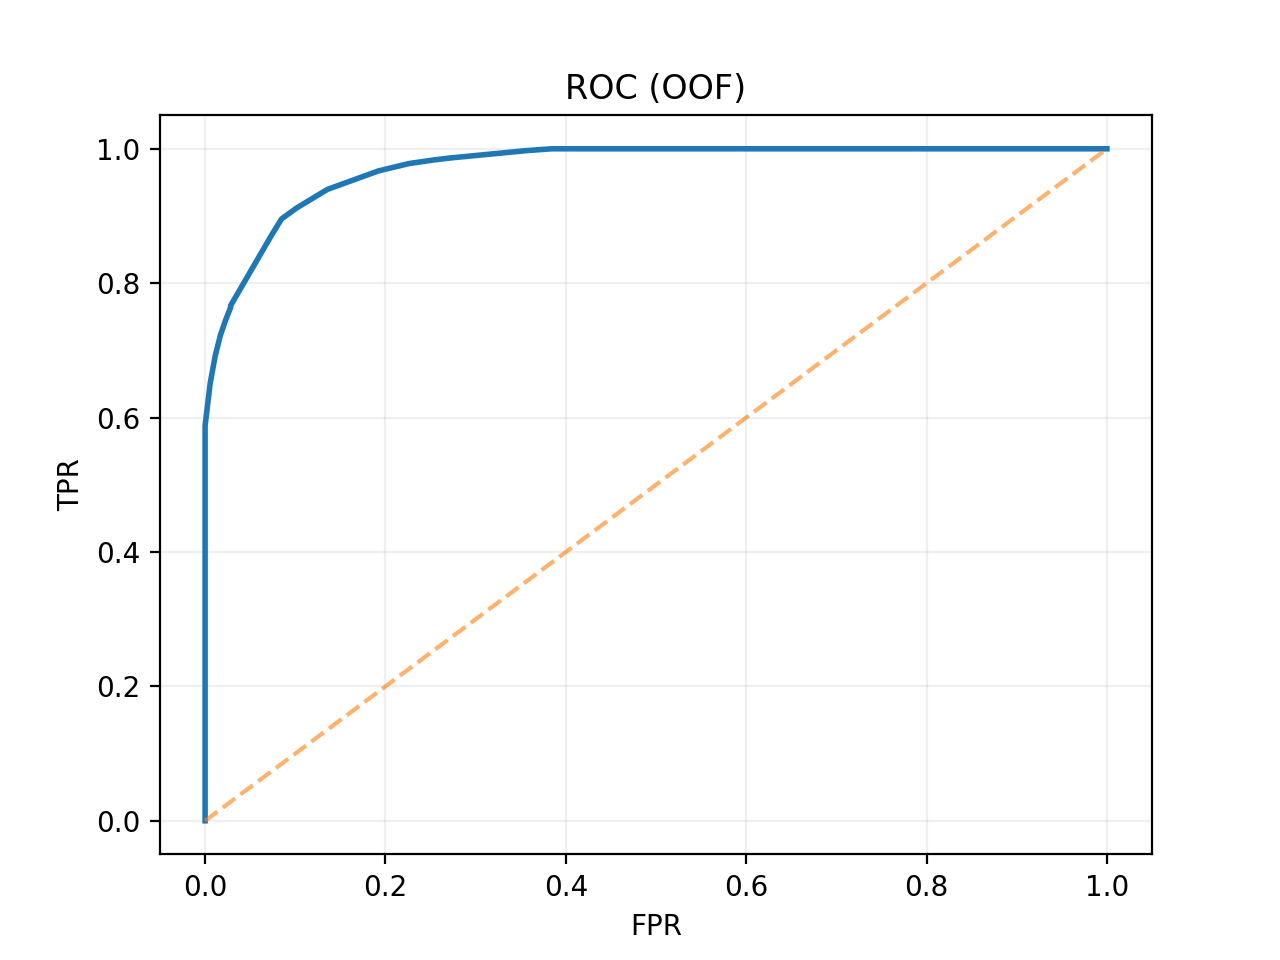

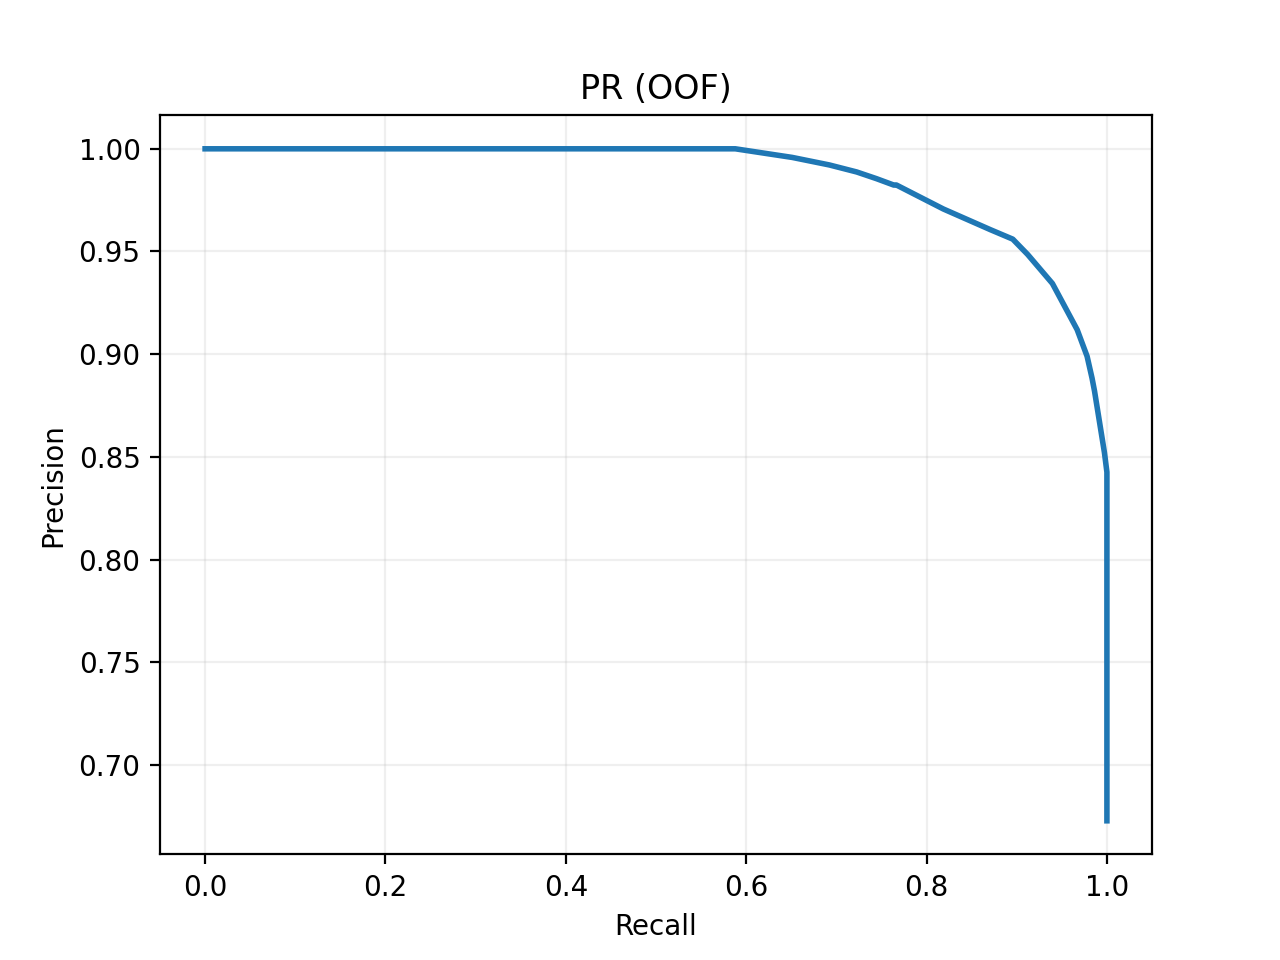

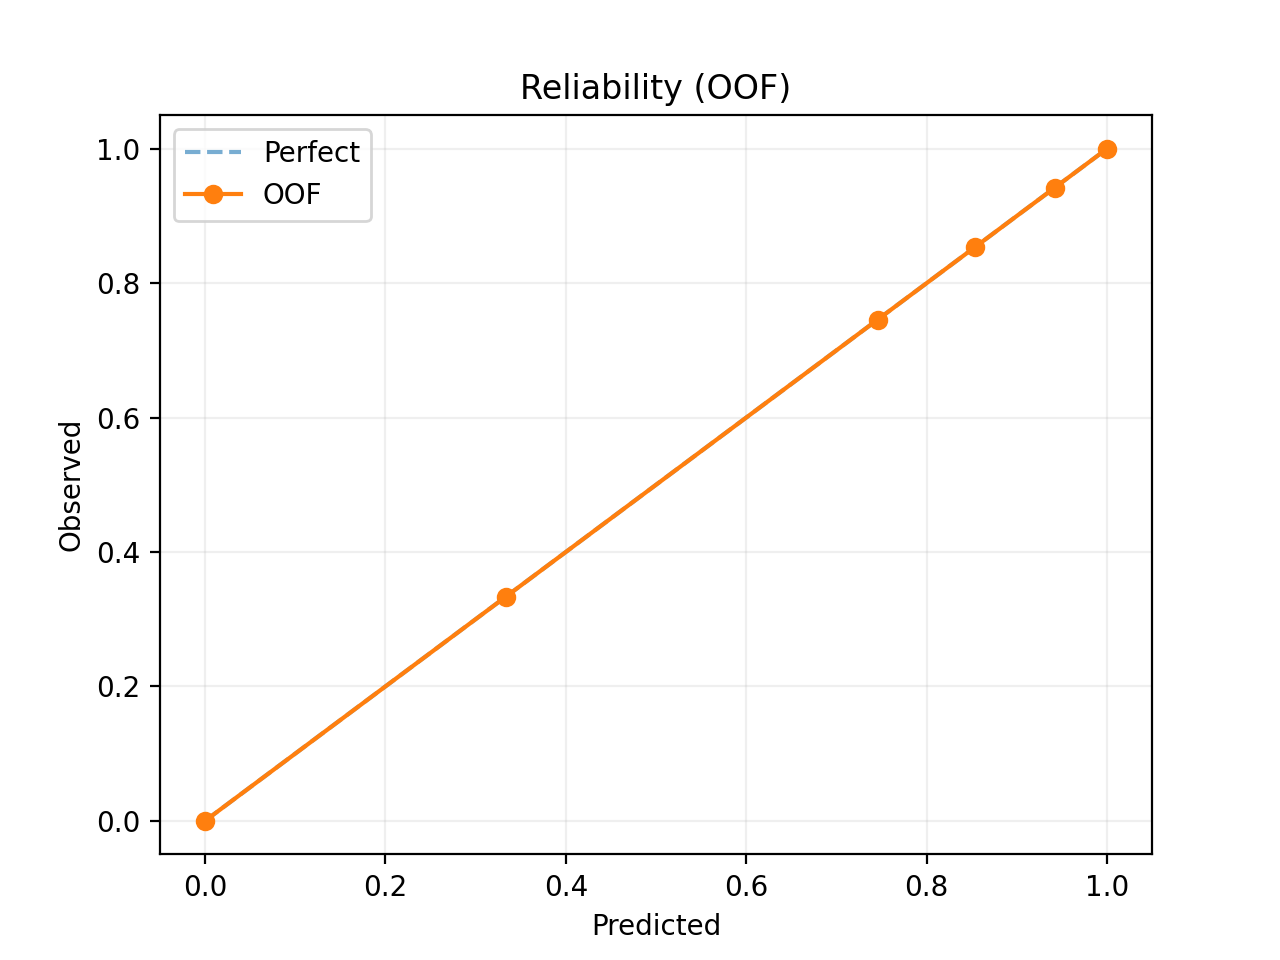

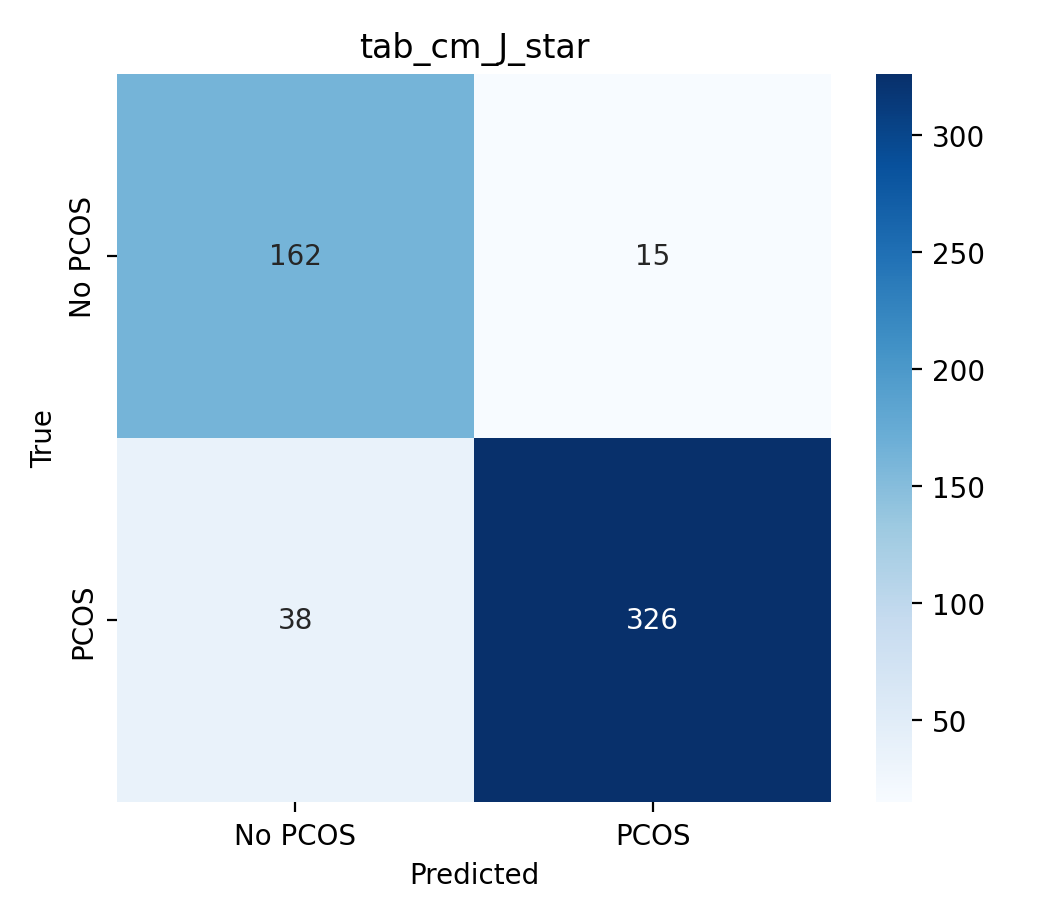

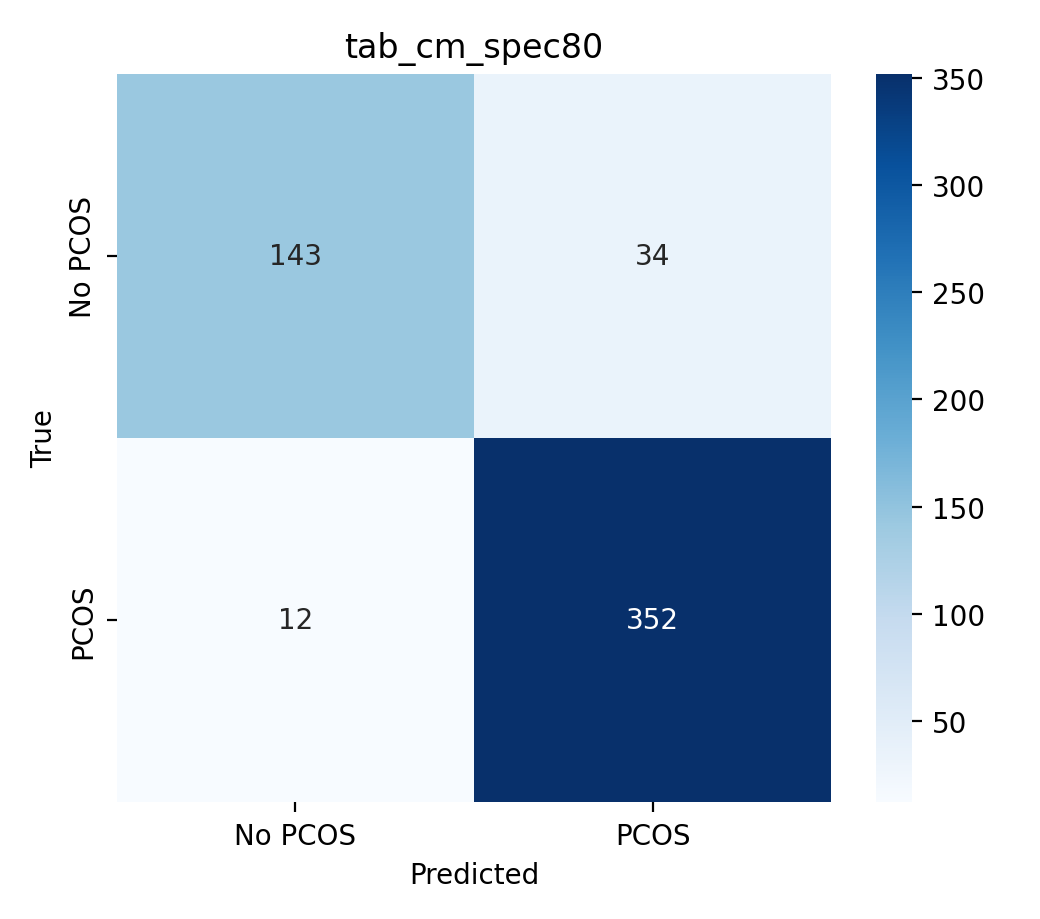

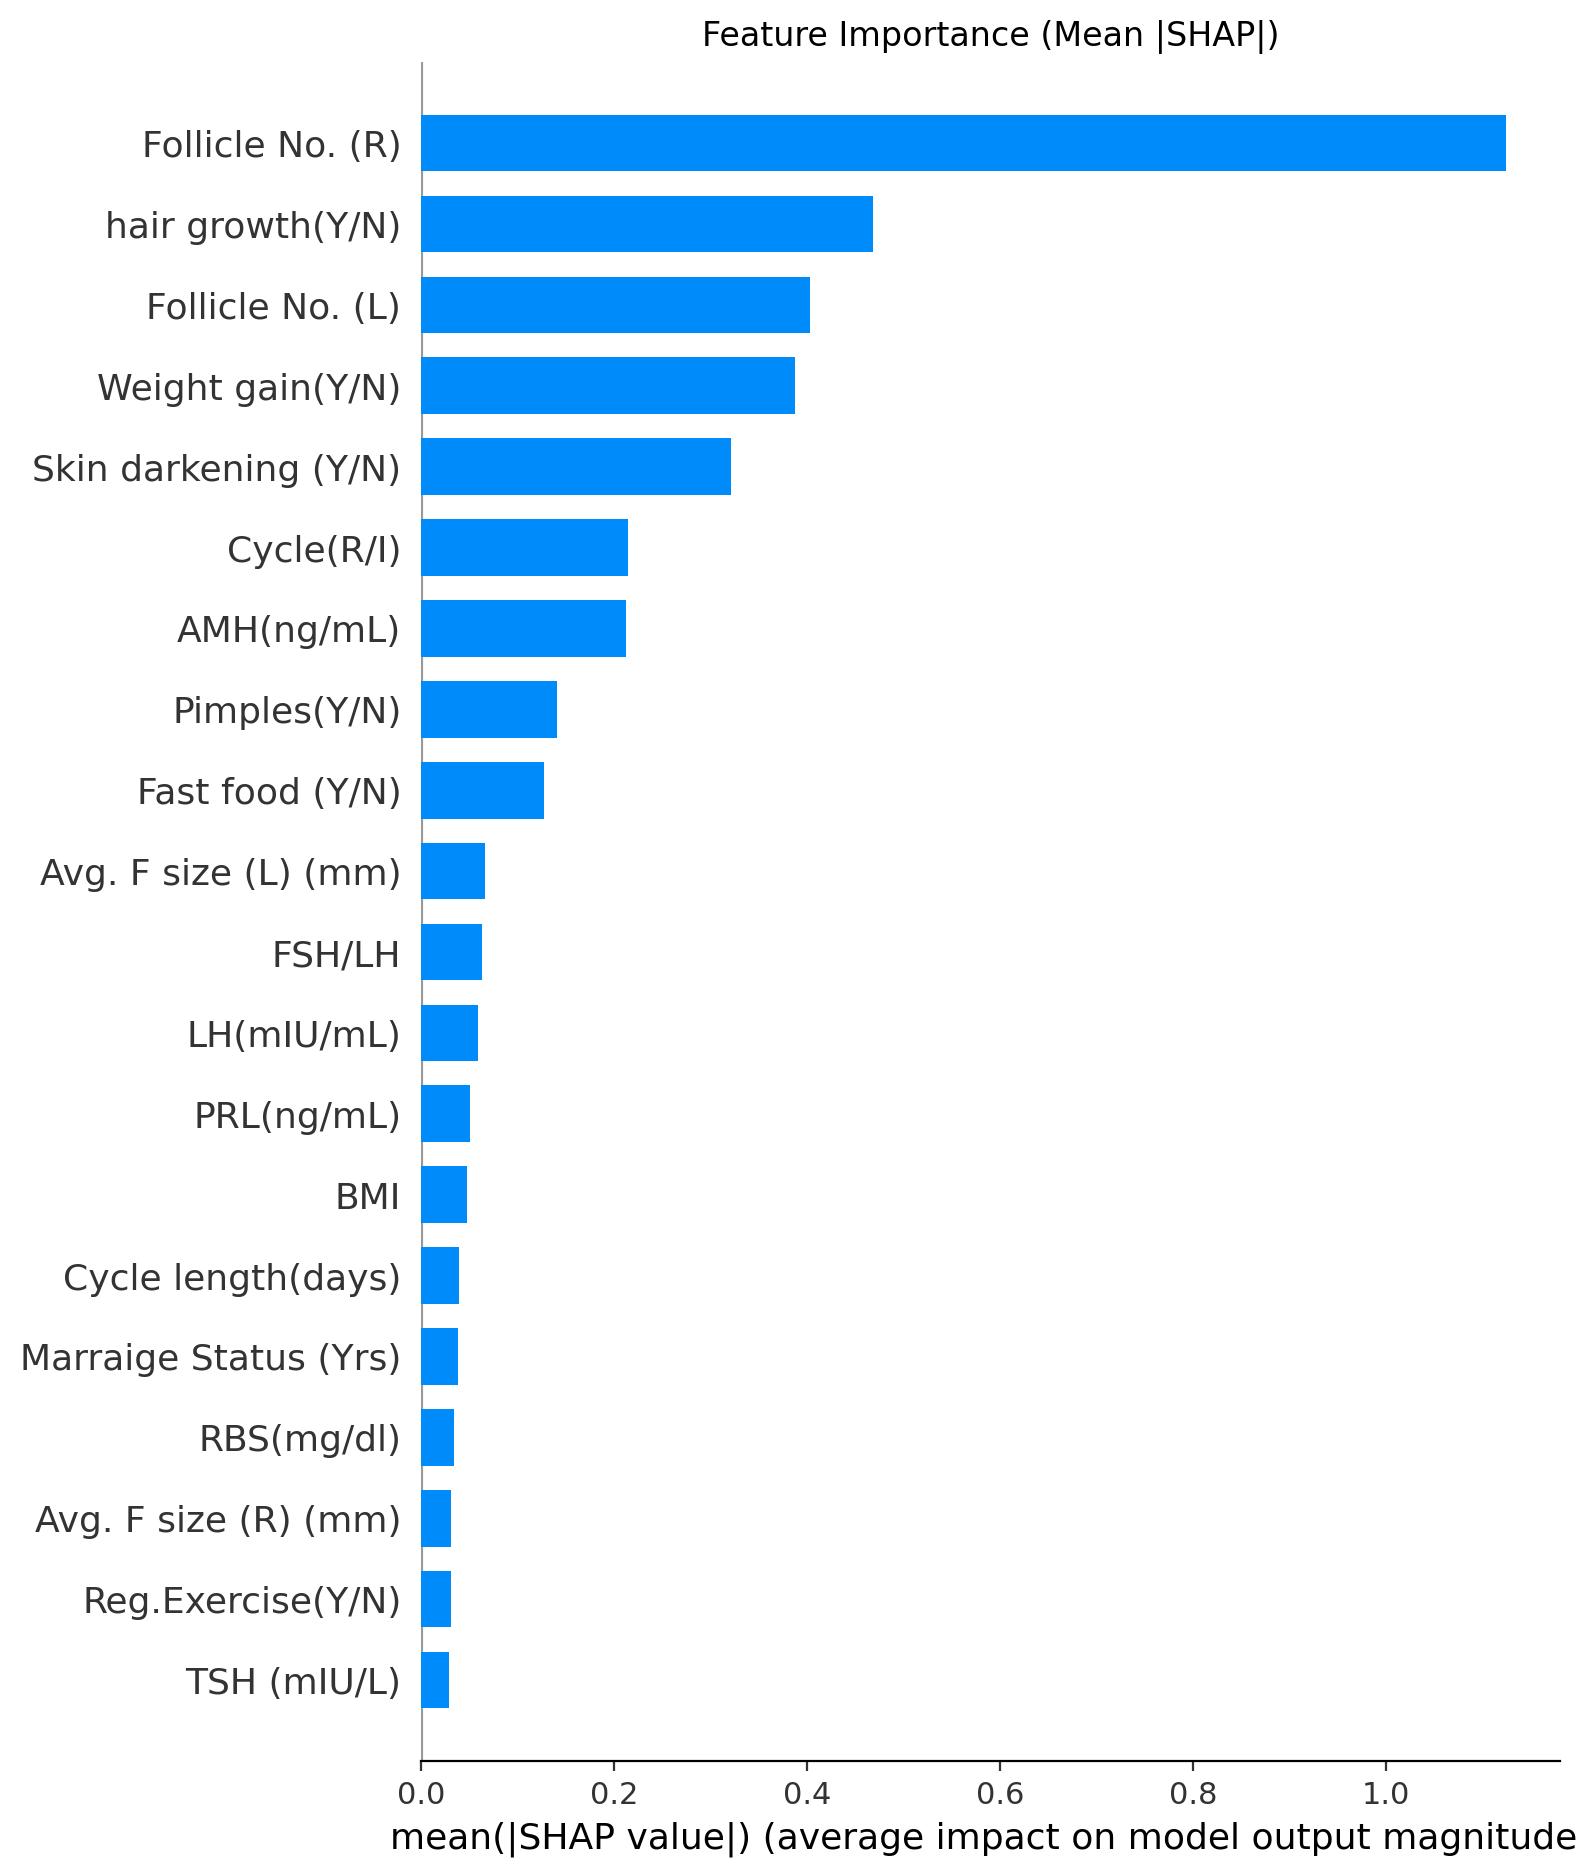

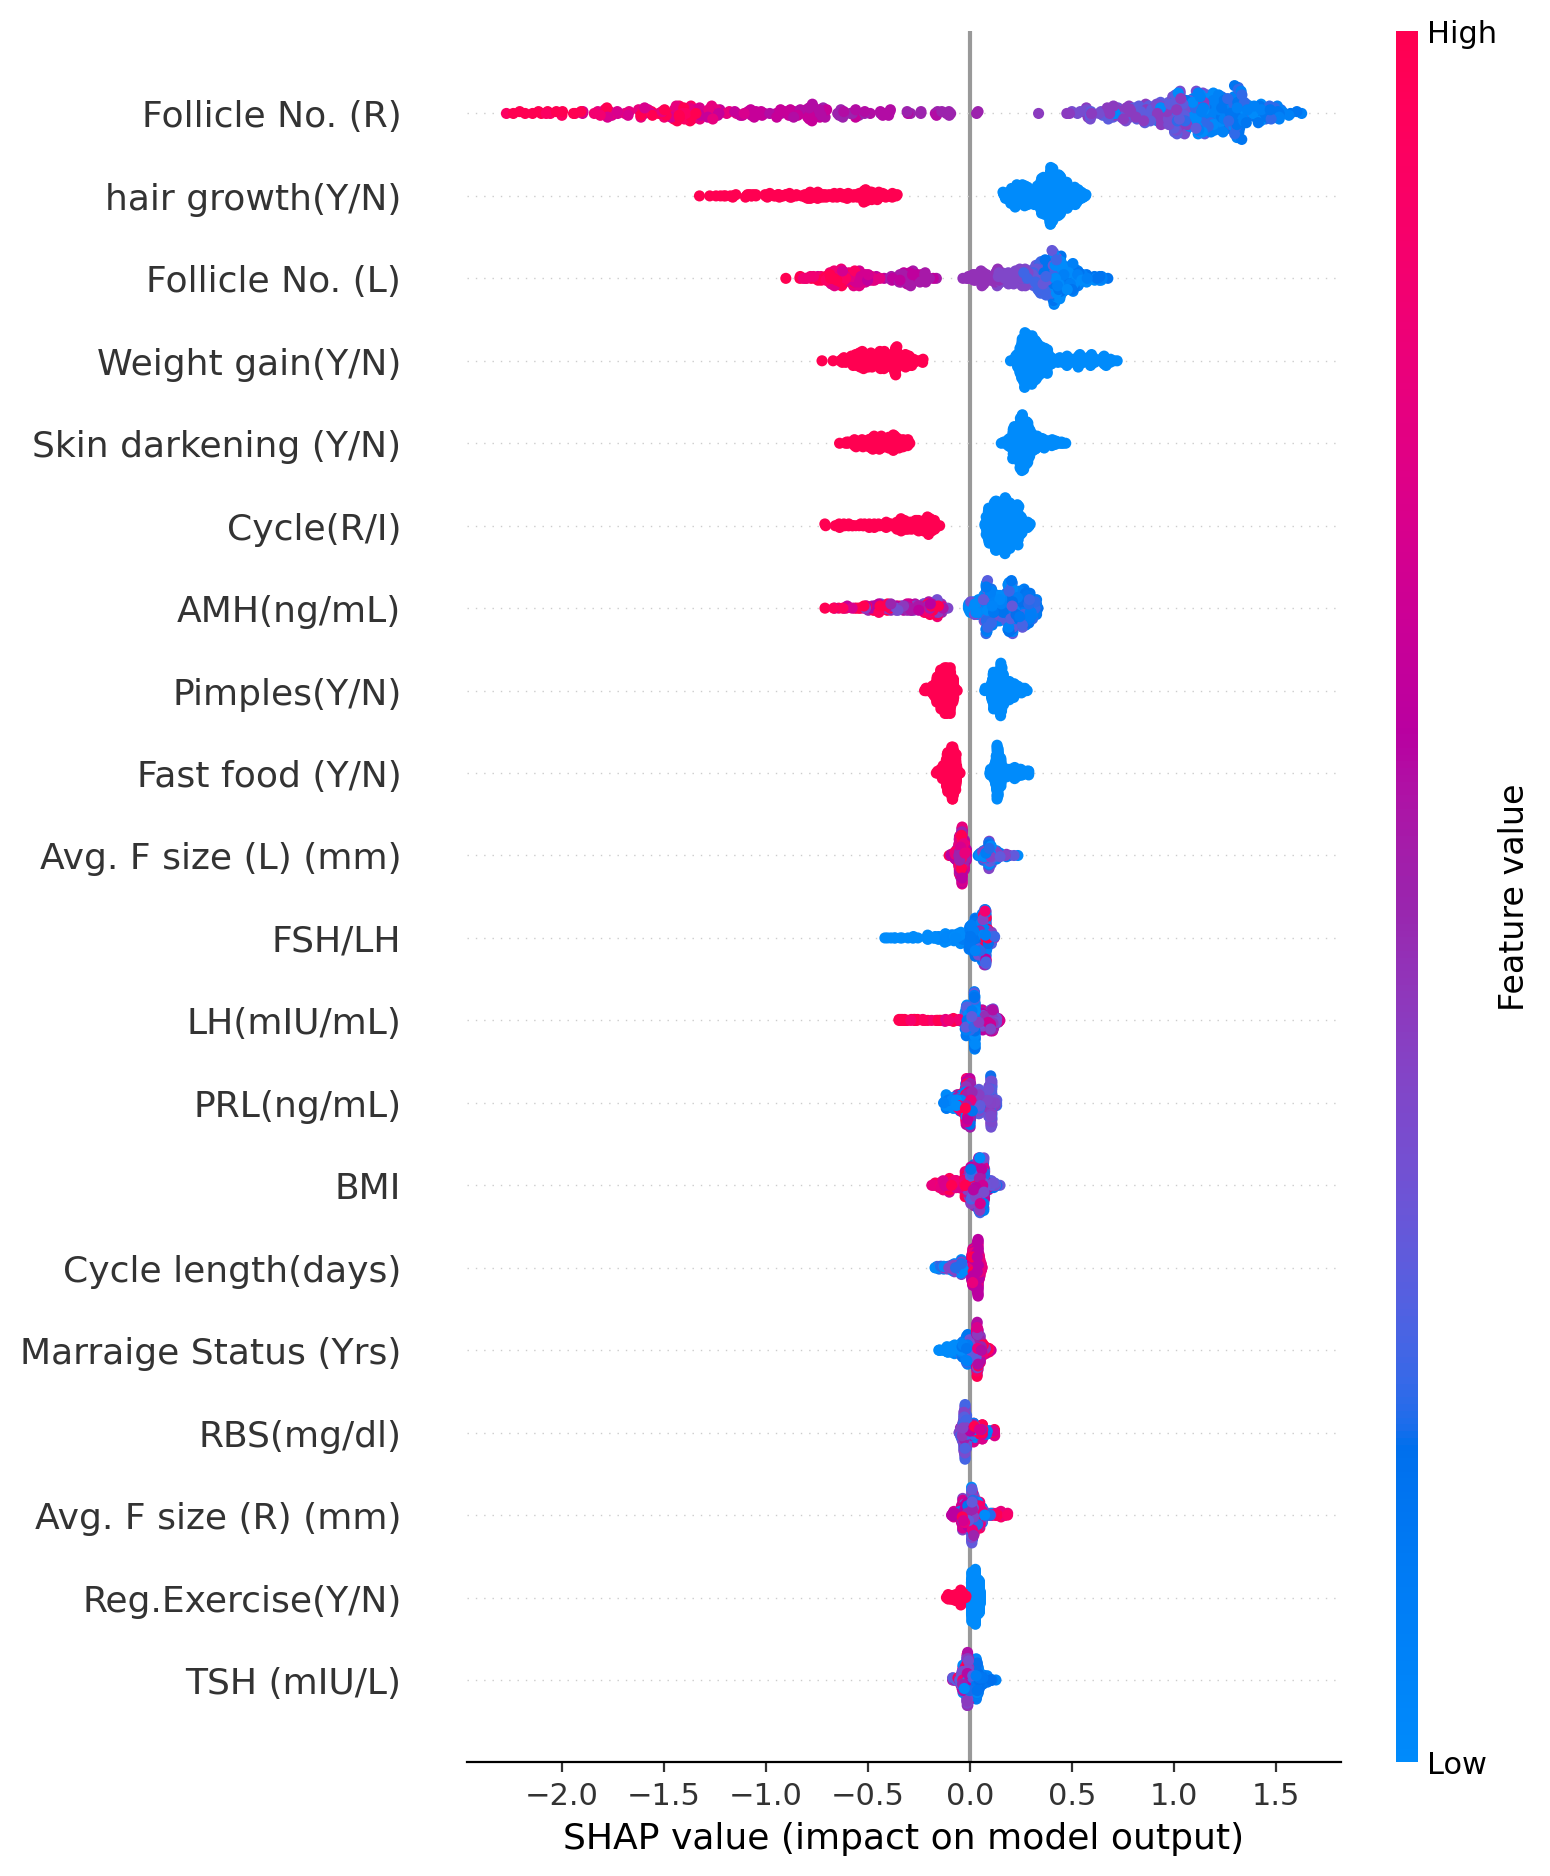

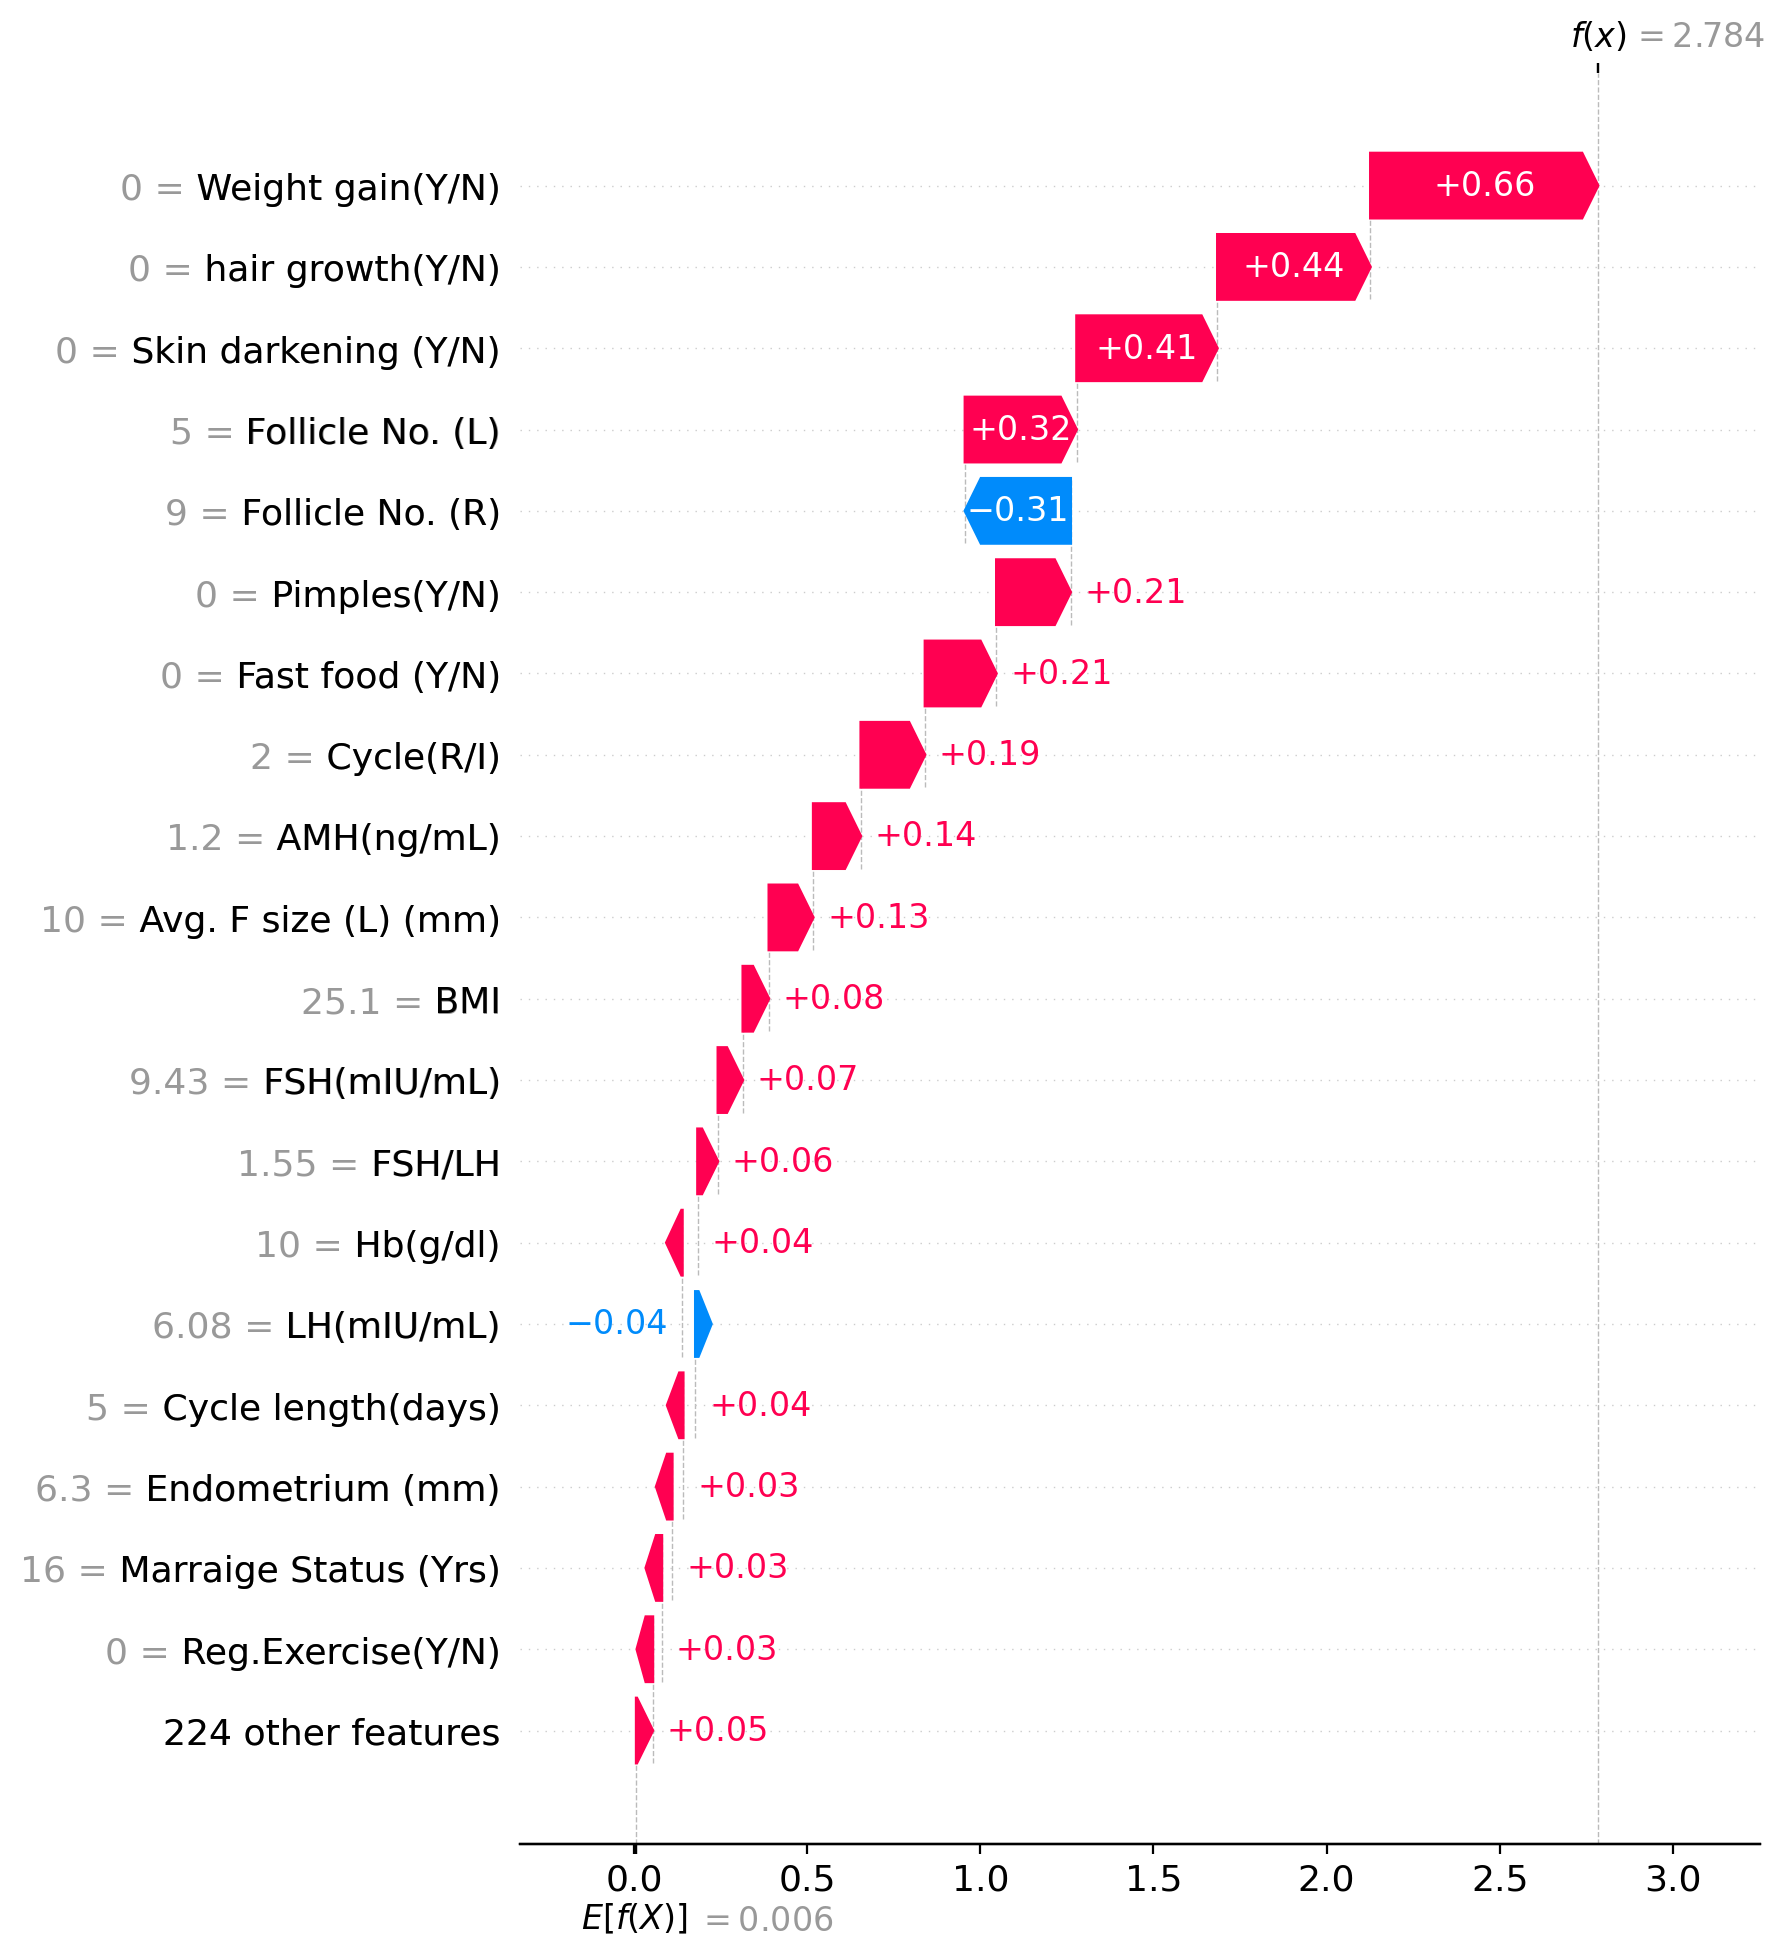

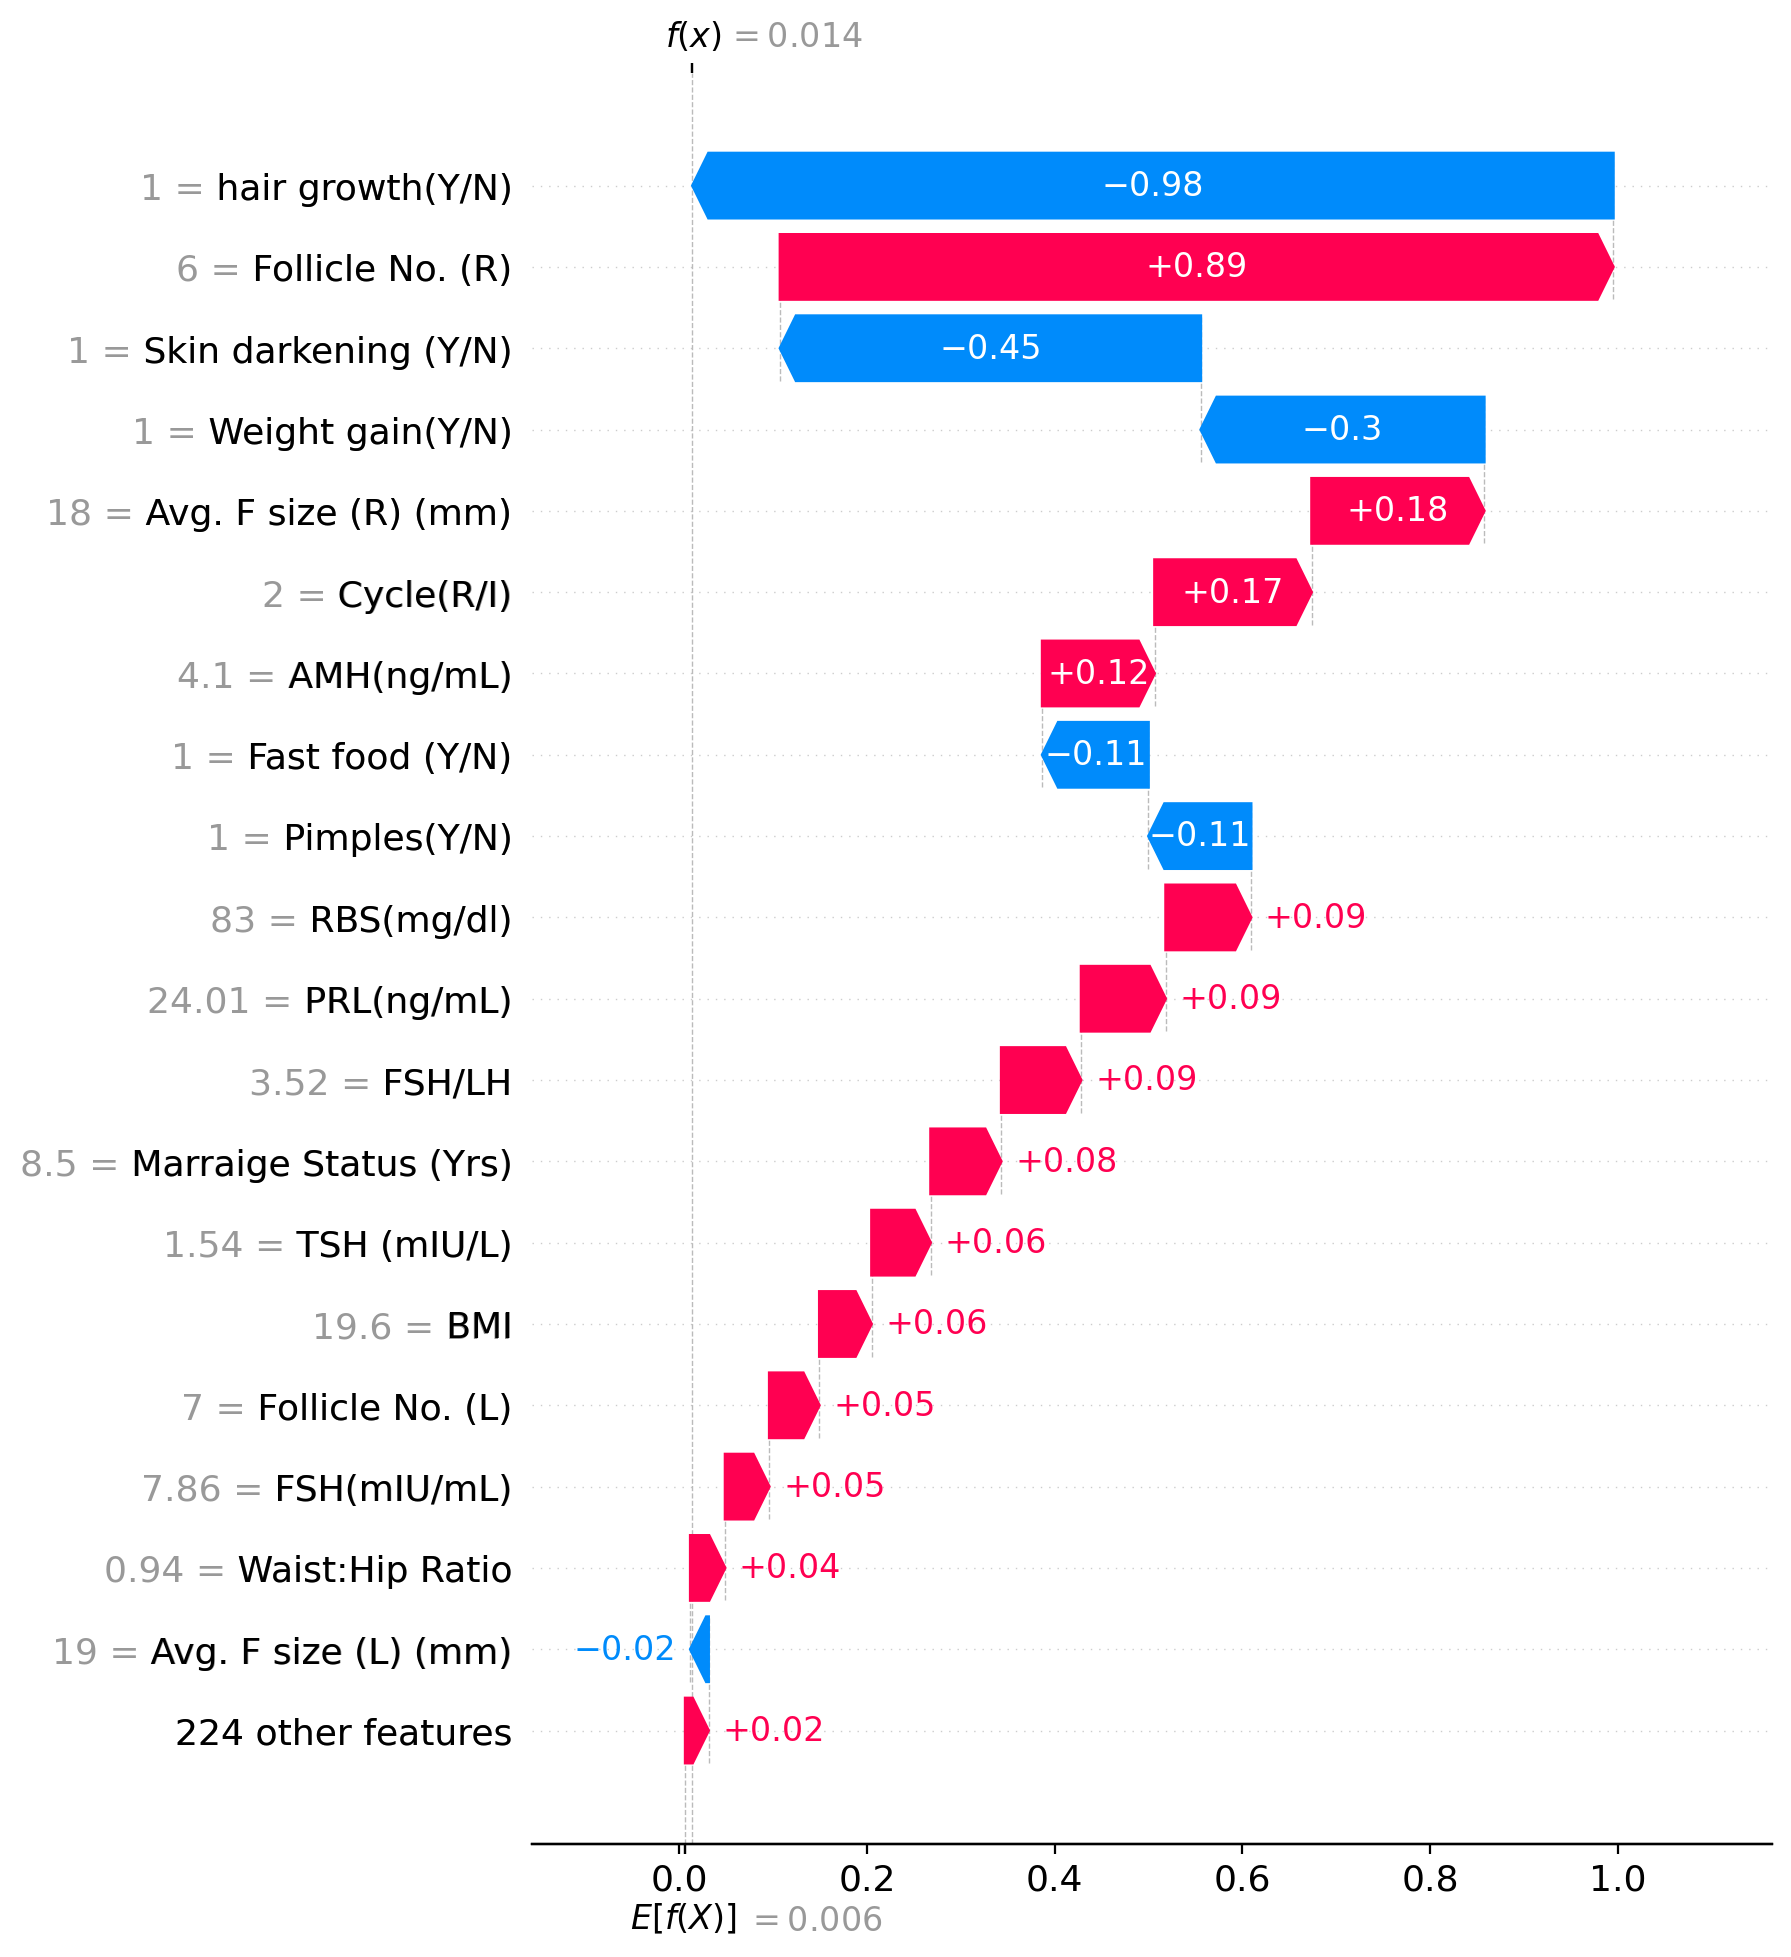

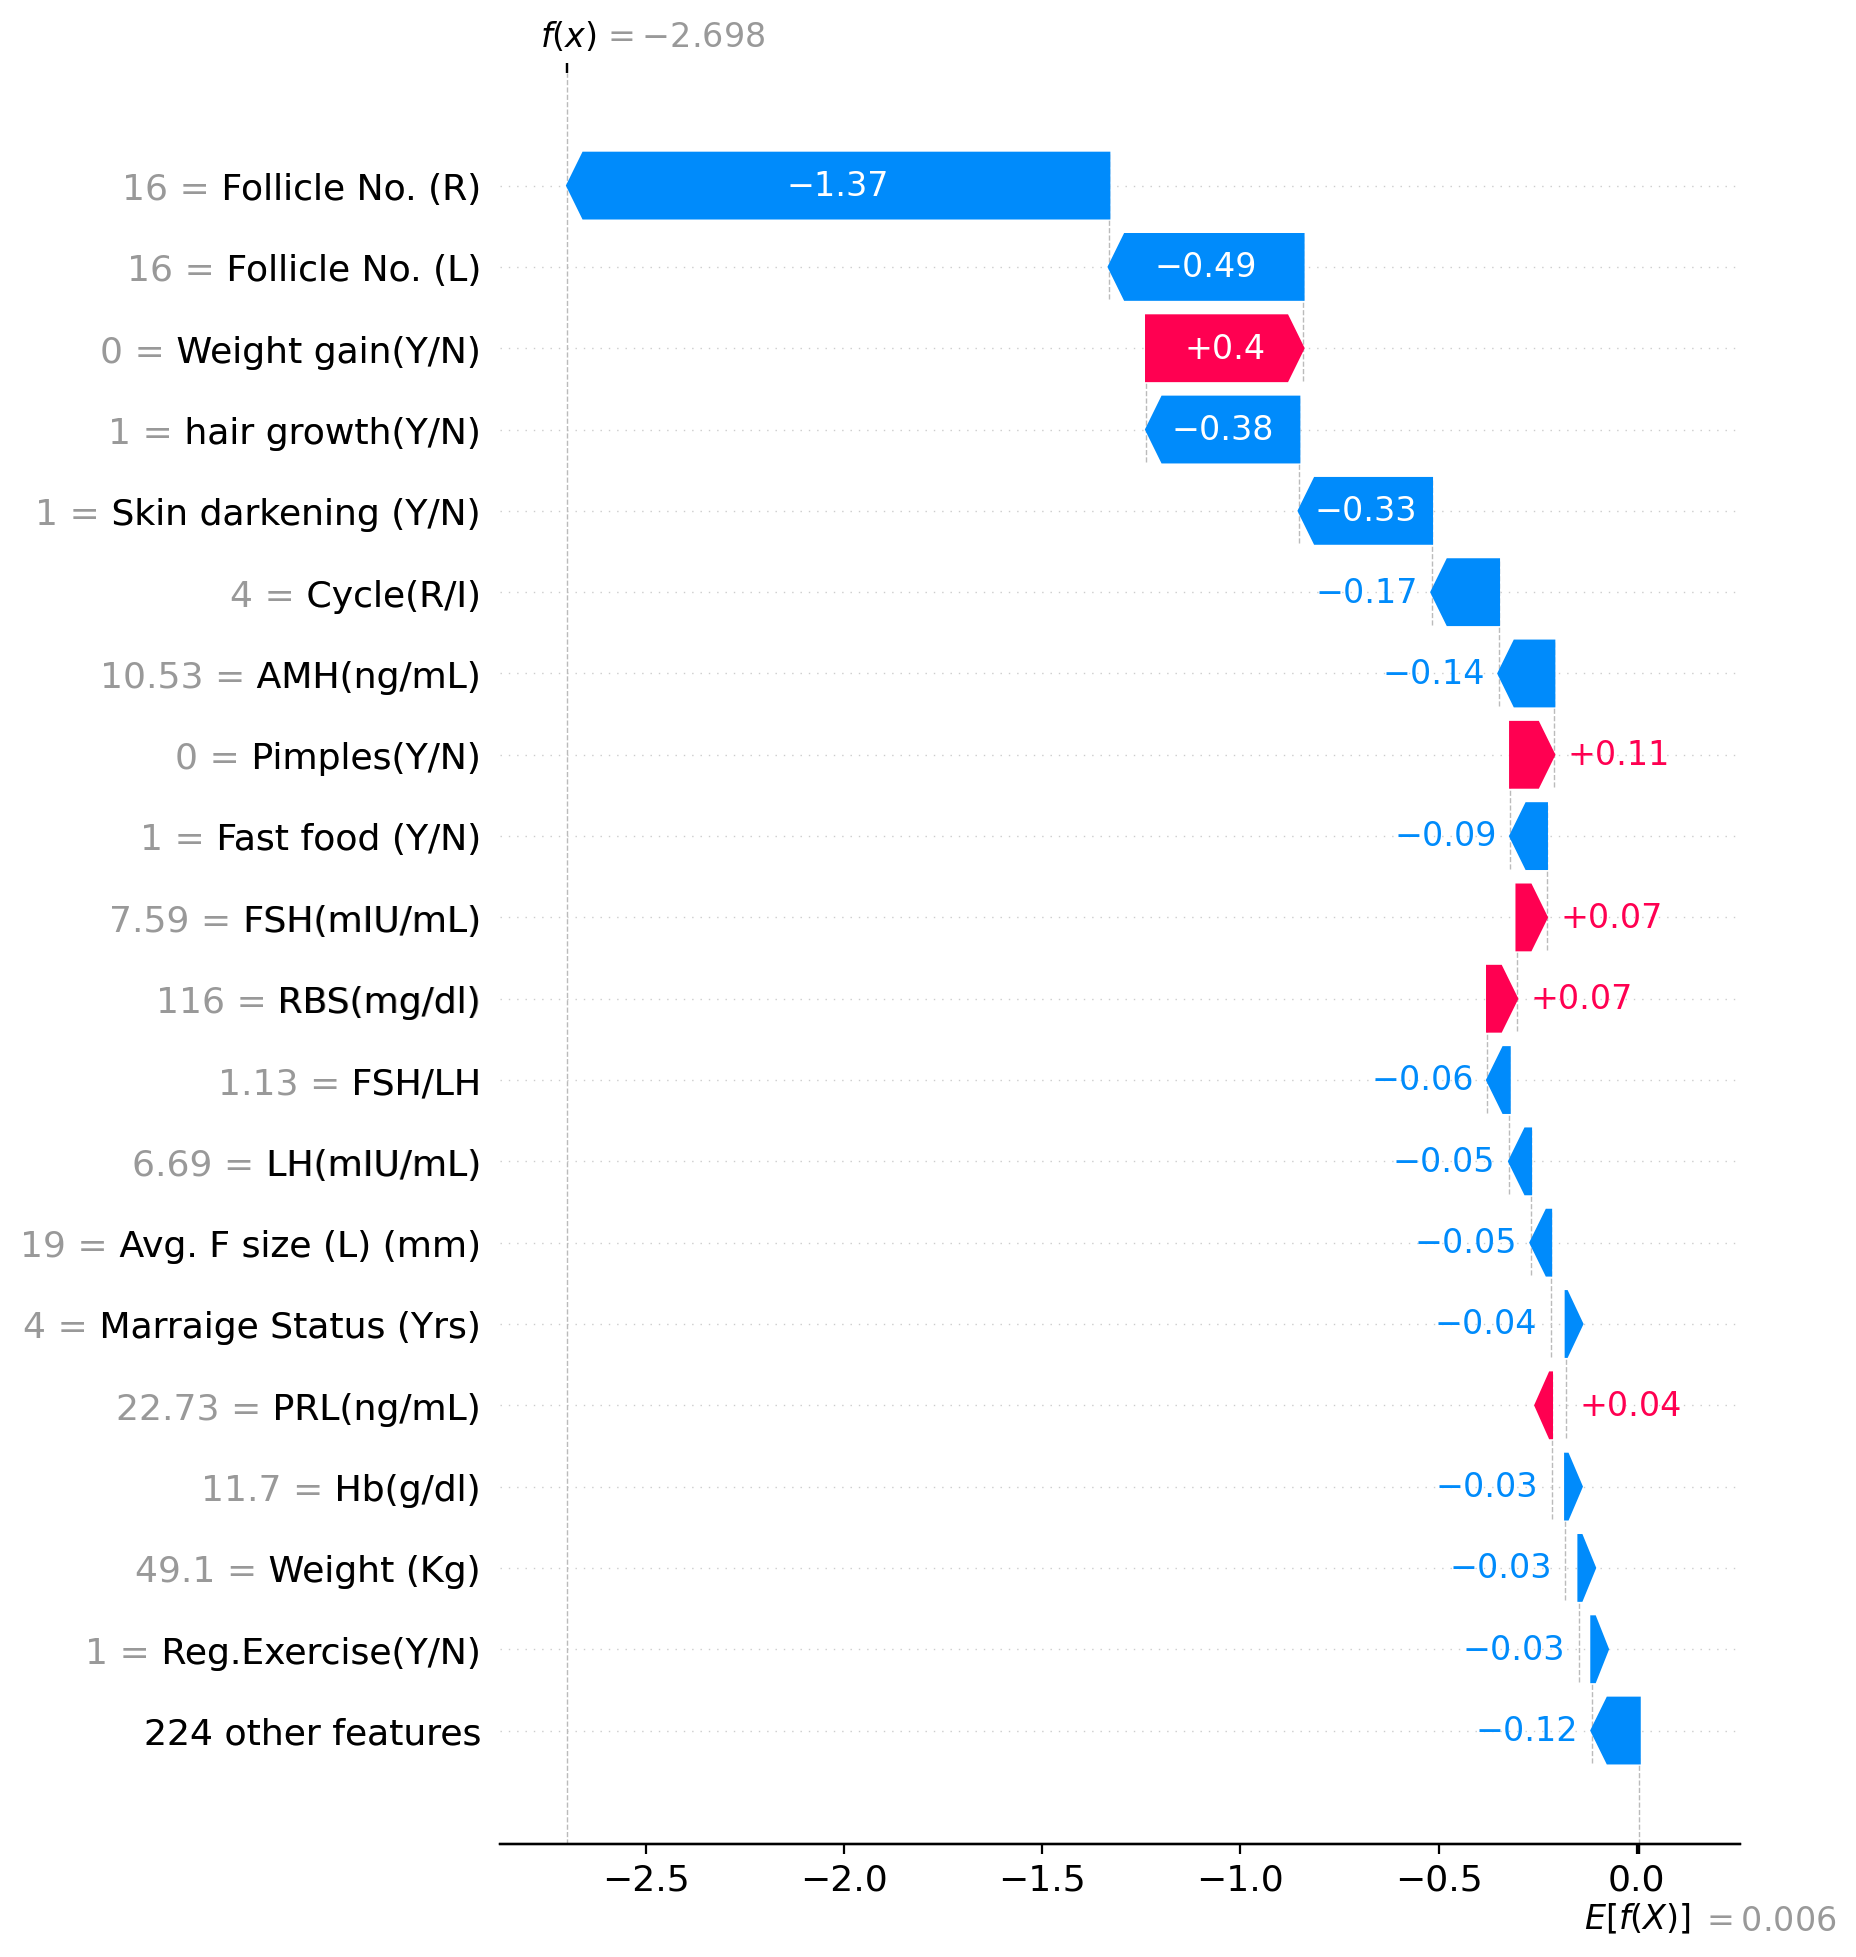

All tab_* files: ['./tab_artifacts/tab_cm_J_star.png', './tab_artifacts/tab_cm_spec80.png', './tab_artifacts/tab_latency_report.json', './tab_artifacts/tab_model_fold1.bin', './tab_artifacts/tab_model_fold2.bin', './tab_artifacts/tab_model_fold3.bin', './tab_artifacts/tab_model_fold4.bin', './tab_artifacts/tab_model_fold5.bin', './tab_artifacts/tab_oof_metrics_ci.json', './tab_artifacts/tab_oof_probs.npy', './tab_artifacts/tab_oof_y.npy', './tab_artifacts/tab_pr.png', './tab_artifacts/tab_reliability.png', './tab_artifacts/tab_roc.png', './tab_artifacts/tab_shap_bar.png', './tab_artifacts/tab_shap_beeswarm.png', './tab_artifacts/tab_shap_case_1.png', './tab_artifacts/tab_shap_case_2.png', './tab_artifacts/tab_shap_case_3.png', './tab_artifacts/tab_thresholds.json']


In [37]:
import os, glob
from IPython.display import Image, display

ARTIFACT_DIR = "./tab_artifacts"
for fn in [
    "tab_roc.png","tab_pr.png","tab_reliability.png",
    "tab_cm_J_star.png","tab_cm_spec80.png",
    "tab_shap_bar.png","tab_shap_beeswarm.png",
    "tab_shap_case_1.png","tab_shap_case_2.png","tab_shap_case_3.png"
]:
    path = os.path.join(ARTIFACT_DIR, fn)
    if os.path.exists(path):
        display(Image(path))
    else:
        print("Missing:", path)

print("All tab_* files:", sorted(glob.glob(os.path.join(ARTIFACT_DIR, "tab_*"))))


In [38]:
# Decision curve from OOF predictions
thr = np.linspace(0.01, 0.99, 99)
n = len(oof_y)
nb = []
for t in thr:
    yhat = (oof_probs >= t).astype(int)
    TP = ((yhat==1) & (oof_y==1)).sum()
    FP = ((yhat==1) & (oof_y==0)).sum()
    nb.append(TP/n - FP/n * (t/(1-t)))
nb = np.array(nb)

# Save CSV + PNG
import pandas as pd, matplotlib.pyplot as plt, os
dc = pd.DataFrame({"threshold": thr, "net_benefit": nb})
dc.to_csv(os.path.join(ARTIFACT_DIR, "tab_decision_curve.csv"), index=False)

plt.figure()
plt.plot(thr, nb, label="Calibrated XGB (OOF)")
prev = oof_y.mean()
treat_all = prev - (1 - prev) * (thr/(1-thr))
plt.plot(thr, treat_all, ":", label="Treat All")
plt.axhline(0, ls="--", c="k", alpha=0.5, label="Treat None")
plt.xlabel("Threshold probability"); plt.ylabel("Net Benefit"); plt.title("Decision Curve (OOF)")
plt.legend(); plt.grid(alpha=0.2)
plt.savefig(os.path.join(ARTIFACT_DIR, "tab_decision_curve.png"), dpi=200); plt.close()
print("Saved decision curve:", os.path.join(ARTIFACT_DIR, "tab_decision_curve.*"))


Saved decision curve: ./tab_artifacts/tab_decision_curve.*


In [39]:
# === Measure pipeline time (preprocess-only vs end-to-end) ===
import time, json, numpy as np, os

reps = 1000
rng  = np.random.default_rng(123)
idxs = rng.integers(0, len(X_full), size=reps)

# Ensure the same preprocessor used in your final model is fit
try:
    _ = preprocessor.transform(X_full.head(1))
except:
    preprocessor.fit(X_full, y_full)

# Preprocessing-only timing
pre_ms = []
for i in idxs:
    x = X_full.iloc[[i]]
    t0 = time.time(); _ = preprocessor.transform(x); t1 = time.time()
    pre_ms.append((t1 - t0) * 1000.0)
pre_ms_median = float(np.median(pre_ms))
pre_ms_p90    = float(np.percentile(pre_ms, 90))

# End-to-end timing with your calibrated final_model (includes preprocessing)
e2e_ms = []
for i in idxs:
    x = X_full.iloc[[i]]
    t0 = time.time(); _ = final_model.predict_proba(x); t1 = time.time()
    e2e_ms.append((t1 - t0) * 1000.0)
e2e_ms_median = float(np.median(e2e_ms))
e2e_ms_p90    = float(np.percentile(e2e_ms, 90))

# Merge into latency JSON
with open(FN_LATENCY) as f:
    lat = json.load(f)
lat.update({
    "preprocess_ms_median": pre_ms_median,
    "preprocess_ms_p90": pre_ms_p90,
    "end2end_ms_median": e2e_ms_median,
    "end2end_ms_p90": e2e_ms_p90
})
with open(FN_LATENCY, "w") as f:
    json.dump(lat, f, indent=2)

print(json.dumps(lat, indent=2))


{
  "per_row_ms_median": 53.864240646362305,
  "per_row_ms_p90": 104.59375381469728,
  "throughput_bs8_samples_per_s": 108.83959522727295,
  "throughput_bs32_samples_per_s": 509.09247136135684,
  "preprocess_ms_median": 6.294131278991699,
  "preprocess_ms_p90": 9.98072624206543,
  "end2end_ms_median": 52.1697998046875,
  "end2end_ms_p90": 88.79415988922119
}


In [40]:
# --- Fix comparison row: units, label note, and model-only latency ---
import os, json, pandas as pd, numpy as np

ARTIFACT_DIR = "./tab_artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

FN_OOF_METRICS = os.path.join(ARTIFACT_DIR, "tab_oof_metrics_ci.json")
FN_THRESHOLDS  = os.path.join(ARTIFACT_DIR, "tab_thresholds.json")
FN_LATENCY     = os.path.join(ARTIFACT_DIR, "tab_latency_report.json")
FN_OOF_Y       = os.path.join(ARTIFACT_DIR, "tab_oof_y.npy")
OUT_CSV        = os.path.join(ARTIFACT_DIR, "tab_compare_row.csv")

# Load artifacts
with open(FN_OOF_METRICS) as f: met = json.load(f)
with open(FN_THRESHOLDS)  as f: thr = json.load(f)
with open(FN_LATENCY)     as f: lat = json.load(f)

# Compute model-only latency (ms) = end-to-end - preprocessing
pre = lat.get("preprocess_ms_median", None)
e2e = lat.get("end2end_ms_median", None)
if pre is not None and e2e is not None:
    model_only_ms = max(float(e2e) - float(pre), 0.0)
else:
    # Fallback if end2end/preprocess not present: use per_row_ms_median as approximation
    model_only_ms = float(lat.get("per_row_ms_median", float("nan")))

# Persist model-only back to JSON for traceability
lat["model_only_ms_median"] = model_only_ms
with open(FN_LATENCY, "w") as f: json.dump(lat, f, indent=2)

# Class balance (prefer y_full if in memory, else use saved OOF labels)
try:
    n  = int(len(y_full))                 # if y_full exists in your notebook
    n1 = int((y_full == 1).sum())
except NameError:
    oof_y = np.load(FN_OOF_Y)
    n  = int(len(oof_y))
    n1 = int(oof_y.sum())
n0 = n - n1
p0 = round(100 * n0 / n, 2)
p1 = round(100 * n1 / n, 2)

# Build the corrected row (units -> img/s; label note -> [1 = healthy])
row = {
    "AUC-ROC (OOF)": f"{met['AUC_ROC']['value']:.4f} (95% CI: {met['AUC_ROC']['ci95'][0]:.3f}–{met['AUC_ROC']['ci95'][1]:.3f})",
    "AP (PR-AUC)":   f"{met['AP_PR']['value']:.4f} (95% CI: {met['AP_PR']['ci95'][0]:.3f}–{met['AP_PR']['ci95'][1]:.3f})",
    "Brier score":   f"{met['Brier']['value']:.4f}",
    "F1 @ 85/85":              f"{thr['thr_85']['metrics']['f1']:.3f}",
    "Sensitivity @ 85/85":     f"{thr['thr_85']['metrics']['sensitivity']:.3f}",
    "Specificity @ 85/85":     f"{thr['thr_85']['metrics']['specificity']:.3f}",
    "Sensitivity @ Spec≥0.80": f"{thr['thr_s80']['metrics']['sensitivity']:.3f}",
    "J* (reported)":           f"{thr['thr_j']['metrics']['J']:.4f}",
    "Threshold @ J*":          f"{thr['thr_j']['thr']:.4f}",
    "Threshold @ Spec≥0.80":   f"{thr['thr_s80']['thr']:.4f}",
    "ms/row (bs=1)":           f"{model_only_ms:.2f} ms",
    "Throughput (bs=8)":       f"{float(lat.get('throughput_bs8_samples_per_s', float('nan'))):.2f} img/s",
    "Throughput (bs=32)":      f"{float(lat.get('throughput_bs32_samples_per_s', float('nan'))):.2f} img/s",
    "Preprocessing (CPU)":     f"{float(pre) if pre is not None else float('nan'):.2f} ms",
    "End-to-end (approx, bs=1)": f"{float(e2e) if e2e is not None else float('nan'):.2f} ms",
    "Class balance (labels)":  f"0={n0} ({p0}%), 1={n1} ({p1}%)  [1 = healthy]"
}

# Write updated CSV
pd.DataFrame([row]).to_csv(OUT_CSV, index=False)
print("Updated:", OUT_CSV)
pd.DataFrame([row])


Updated: ./tab_artifacts/tab_compare_row.csv


,AUC-ROC (OOF),AP (PR-AUC),Brier score,F1 @ 85/85,Sensitivity @ 85/85,Specificity @ 85/85,Sensitivity @ Spec≥0.80,J* (reported),Threshold @ J*,Threshold @ Spec≥0.80,ms/row (bs=1),Throughput (bs=8),Throughput (bs=32),Preprocessing (CPU),"End-to-end (approx, bs=1)",Class balance (labels)
0,0.9727 (95% CI: 0.961–0.983),0.9845 (95% CI: 0.977–0.991),0.0595,0.925,0.896,0.915,0.967,0.8109,0.8182,0.5000,45.88 ms,108.84 img/s,509.09 img/s,6.29 ms,52.17 ms,"0=177 (32.72%), 1=364 (67.28%) [1 = healthy]"


In [41]:
import shutil, os
ARTIFACT_DIR = "./tab_artifacts"
src = os.path.join(ARTIFACT_DIR, "tab_latency_report.json")
dst = os.path.join(ARTIFACT_DIR, "tab_latency_report_ref.json")
shutil.copyfile(src, dst)  # creates the reference file used by the appendix
print("Created:", dst)


Created: ./tab_artifacts/tab_latency_report_ref.json


In [42]:
# Clinical Appendix — HTML (v2): prefers reference latency, adds label banner + class-balance
import os, json, glob, base64
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ARTIFACT_DIR = "./tab_artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# ---- File handles
FN_OOF_METRICS = os.path.join(ARTIFACT_DIR, "tab_oof_metrics_ci.json")
FN_THRESHOLDS  = os.path.join(ARTIFACT_DIR, "tab_thresholds.json")
FN_LATENCY_REF = os.path.join(ARTIFACT_DIR, "tab_latency_report_ref.json")  # preferred if exists
FN_LATENCY_LIVE= os.path.join(ARTIFACT_DIR, "tab_latency_report.json")
FN_OOF_Y       = os.path.join(ARTIFACT_DIR, "tab_oof_y.npy")

# ---- Helpers
def _read_json(p):
    try:
        with open(p) as f:
            return json.load(f)
    except Exception:
        return None

def _img_data_uri(p):
    if not os.path.exists(p):
        return None
    with open(p, "rb") as f:
        return "data:image/png;base64," + base64.b64encode(f.read()).decode("ascii")

def _fmt(x, digs=4):
    if x is None: return "—"
    if isinstance(x, (int, float)): return f"{x:.{digs}f}"
    return str(x)

# ---- Load artifacts
met = _read_json(FN_OOF_METRICS) or {}
thr = _read_json(FN_THRESHOLDS) or {}
lat = _read_json(FN_LATENCY_REF) or _read_json(FN_LATENCY_LIVE) or {}

# ---- Label banner + class balance (prefer saved OOF labels)
if os.path.exists(FN_OOF_Y):
    y = np.load(FN_OOF_Y).astype(int)
elif "y_full" in globals():
    y = np.asarray(y_full).astype(int)
else:
    y = None

cb_png = os.path.join(ARTIFACT_DIR, "tab_class_balance.png")
if (y is not None) and (not os.path.exists(cb_png)):
    # Build & save class-balance bar
    n0, n1 = int((y==0).sum()), int((y==1).sum())
    tot = max(1, len(y))
    pct0, pct1 = n0/tot*100.0, n1/tot*100.0
    plt.figure(figsize=(4.6,3.2))
    bars = plt.bar(["PCOS (0)", "Healthy (1)"], [n0, n1])
    for b, p, c in zip(bars, [pct0, pct1], [n0, n1]):
        plt.text(b.get_x()+b.get_width()/2, b.get_height(), f"{c}\n({p:.1f}%)", ha="center", va="bottom")
    plt.title("Class Balance (OOF labels)")
    plt.ylabel("Count"); plt.tight_layout()
    plt.savefig(cb_png, dpi=150); plt.close()

# ---- Collect figure paths (use what exists)
FIGS = {
    "ROC Curve (OOF)":           os.path.join(ARTIFACT_DIR, "tab_roc.png"),
    "PR Curve (OOF)":            os.path.join(ARTIFACT_DIR, "tab_pr.png"),
    "Reliability Diagram":       os.path.join(ARTIFACT_DIR, "tab_reliability.png"),
    "Confusion Matrix @ J*":     os.path.join(ARTIFACT_DIR, "tab_cm_J_star.png"),
    "Confusion Matrix @ Spec≥0.80": os.path.join(ARTIFACT_DIR, "tab_cm_spec80.png"),
    "Decision Curve":            os.path.join(ARTIFACT_DIR, "tab_decision_curve.png"),
    "SHAP (Mean |SHAP|) Bar":    os.path.join(ARTIFACT_DIR, "tab_shap_bar.png"),
    "SHAP Beeswarm":             os.path.join(ARTIFACT_DIR, "tab_shap_beeswarm.png"),
    "Local SHAP Case 1":         os.path.join(ARTIFACT_DIR, "tab_shap_case_1.png"),
    "Local SHAP Case 2":         os.path.join(ARTIFACT_DIR, "tab_shap_case_2.png"),
    "Local SHAP Case 3":         os.path.join(ARTIFACT_DIR, "tab_shap_case_3.png"),
    "Class Balance":             cb_png if os.path.exists(cb_png) else None,
}

# ---- Build small tables
def _metrics_table_html(met):
    rows = []
    if "AUC_ROC" in met:
        rows.append(("AUC-ROC (OOF)", _fmt(met["AUC_ROC"]["value"],4),
                     f"[{_fmt(met['AUC_ROC']['ci95'][0],3)}, {_fmt(met['AUC_ROC']['ci95'][1],3)}]"))
    if "AP_PR" in met:
        rows.append(("AP (PR-AUC)", _fmt(met["AP_PR"]["value"],4),
                     f"[{_fmt(met['AP_PR']['ci95'][0],3)}, {_fmt(met['AP_PR']['ci95'][1],3)}]"))
    if "Brier" in met:
        rows.append(("Brier score", _fmt(met["Brier"]["value"],4), ""))
    if not rows:
        return ""
    body = "".join([f"<tr><td>{a}</td><td>{b}</td><td>{c}</td></tr>" for a,b,c in rows])
    return f"""
    <h2>OOF Metrics (with 95% CIs)</h2>
    <table>
      <tr><th>Metric</th><th>Value</th><th>95% CI</th></tr>
      {body}
    </table>
    """

def _ops_table_html(thr):
    def _row(name, key):
        if key not in thr: return ""
        t = thr[key].get("thr", None)
        m = thr[key].get("metrics", {})
        return f"<tr><td>{name}</td><td>{_fmt(t,4)}</td><td>{_fmt(m.get('sensitivity'))}</td><td>{_fmt(m.get('specificity'))}</td><td>{_fmt(m.get('accuracy'))}</td><td>{_fmt(m.get('f1'))}</td><td>{_fmt(m.get('J'))}</td></tr>"
    rows = _row("Youden's J*", "thr_j") + _row("Spec≥0.80", "thr_s80") + _row("85/85 target", "thr_85")
    if not rows: return ""
    return f"""
    <h2>Operating Points</h2>
    <table>
      <tr><th>Operating point</th><th>Threshold</th><th>Sensitivity</th><th>Specificity</th><th>Accuracy</th><th>F1</th><th>J</th></tr>
      {rows}
    </table>
    """

def _latency_table_html(lat):
    if not lat: return ""
    # Compute derived model-only ms if present
    model_only = lat.get("model_only_ms_median")
    if model_only is None and "end2end_ms_median" in lat and "preprocess_ms_median" in lat:
        model_only = max(0.0, float(lat["end2end_ms_median"])-float(lat["preprocess_ms_median"]))
    rows = []
    def add(name, key, unit="ms"):
        v = lat.get(key)
        if v is not None:
            rows.append((name, _fmt(float(v),2), unit))
    add("Per-row median (model-only)", "per_row_ms_median", "ms")
    add("Per-row p90 (model-only)",    "per_row_ms_p90",    "ms")
    add("Throughput (bs=8)",           "throughput_bs8_samples_per_s",  "rows/s")
    add("Throughput (bs=32)",          "throughput_bs32_samples_per_s", "rows/s")
    add("Preprocessing (CPU) median",  "preprocess_ms_median", "ms")
    add("Preprocessing (CPU) p90",     "preprocess_ms_p90",    "ms")
    add("End-to-end median (approx, bs=1)", "end2end_ms_median", "ms")
    add("End-to-end p90 (approx, bs=1)",    "end2end_ms_p90",    "ms")
    if model_only is not None:
        rows.append(("Model-only (derived)", _fmt(model_only,2), "ms"))
    body = "".join([f"<tr><td>{a}</td><td>{b}</td><td>{c}</td></tr>" for a,b,c in rows])
    return f"""
    <h2>Latency & Throughput</h2>
    <table>
      <tr><th>Metric</th><th>Value</th><th>Unit</th></tr>
      {body}
    </table>
    """

# ---- CSS
styles = """
<style>
body{font-family:system-ui,-apple-system,Segoe UI,Roboto,sans-serif;margin:16px;line-height:1.35}
h1{margin:0 0 6px 0}
small{color:#666}
.grid{display:grid;grid-template-columns:repeat(auto-fit,minmax(280px,1fr));gap:12px}
.card{border:1px solid #e5e5e5;border-radius:10px;padding:12px;background:#fff;box-shadow:0 2px 5px rgba(0,0,0,.04)}
.kpi{display:grid;grid-template-columns:repeat(auto-fit,minmax(180px,1fr));gap:8px}
.kpi .card{padding:10px}
table{border-collapse:collapse;width:100%;font-size:14px}
th,td{border:1px solid #eaeaea;padding:6px 8px;text-align:left}
th{background:#fafafa;font-weight:600}
.img{width:100%;height:auto;border-radius:8px;border:1px solid #eee}
.banner{padding:10px;border:1px dashed #bbb;border-radius:8px;background:#fcfcff;margin:8px 0}
.files{columns:2}
code{background:#f5f5f5;padding:1px 4px;border-radius:4px}
</style>
"""

# ---- Header & banner
ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
label_line = "Labels: <b>0 = PCOS (unhealthy), 1 = healthy</b>"
counts_line = ""
if y is not None:
    n0, n1 = int((y==0).sum()), int((y==1).sum())
    pct0, pct1 = n0/len(y)*100.0, n1/len(y)*100.0
    counts_line = f" | Class balance (OOF): 0={n0} ({pct0:.2f}%), 1={n1} ({pct1:.2f}%)"

# ---- KPIs (thresholds)
kpi_html = ""
def _kbox(title, val):
    if val is None: return ""
    return f"<div class='card'><div style='font-size:12px;color:#555'>{title}</div><div style='font-weight:700'>{_fmt(val,4)}</div></div>"
if "thr_j" in thr:    kpi_html += _kbox("threshold @ J*", thr["thr_j"].get("thr"))
if "thr_s80" in thr:  kpi_html += _kbox("threshold @ Spec≥0.80", thr["thr_s80"].get("thr"))
if "thr_85" in thr:   kpi_html += _kbox("threshold @ 85/85", thr["thr_85"].get("thr"))

# ---- Core figures grid
fig_cards = []
for title, path in FIGS.items():
    if not path or not os.path.exists(path):
        continue
    uri = _img_data_uri(path)
    fig_cards.append(f"<div class='card'><div style='font-weight:600;margin-bottom:6px'>{title}</div><img class='img' src='{uri}'></div>")
figs_html = "<div class='grid'>" + "".join(fig_cards) + "</div>"

# ---- Artifact inventory
all_files = sorted([os.path.basename(p) for p in glob.glob(os.path.join(ARTIFACT_DIR, "tab_*"))])
files_html = "<div class='files'>" + "<br>".join(all_files) + "</div>"

# ---- Compose HTML
html = f"""<!DOCTYPE html>
<html><head><meta charset="utf-8"><title>Clinical Appendix — PCOS (Tabular Model)</title>{styles}</head>
<body>
  <h1>Clinical Appendix — PCOS (Tabular Model)</h1>
  <small>Generated: {ts}</small>
  <div class="banner">{label_line}{counts_line}</div>

  <h2>Key Values</h2>
  <div class="kpi">{kpi_html}</div>

  { _metrics_table_html(met) }
  { _ops_table_html(thr) }
  { _latency_table_html(lat) }

  <h2>Core Figures</h2>
  {figs_html}

  <h2>Artifact Inventory</h2>
  {files_html}
</body></html>
"""

out_html = os.path.join(ARTIFACT_DIR, "clinical_appendix.html")
with open(out_html, "w", encoding="utf-8") as f:
    f.write(html)

print("Wrote:", out_html)
print("Latency file used:", ("tab_latency_report_ref.json" if os.path.exists(FN_LATENCY_REF) else "tab_latency_report.json"))


Wrote: ./tab_artifacts/clinical_appendix.html
Latency file used: tab_latency_report_ref.json


In [43]:
import shutil
import os
from google.colab import files

# Define the directory to zip and the name of the zip file
directory_to_zip = "./tab_artifacts"
zip_filename = "pcos_artifacts.zip"

# Create the zip file
shutil.make_archive(zip_filename.replace(".zip", ""), 'zip', directory_to_zip)

# Provide a download link
print(f"Zipped artifacts to {zip_filename}. You can download it using the link below.")
files.download(zip_filename)

Zipped artifacts to pcos_artifacts.zip. You can download it using the link below.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>